#  H&M E-commerce Data - Exploratory Data Analysis

## Business Context
This notebook performs comprehensive exploratory data analysis on H&M's fashion retail dataset containing:
- **31.8M transactions** over 2 years (2018-2020)
- **1.37M customers** with demographic profiles
- **105K products** with detailed attributes

## Objectives
1. Understand data quality and structure
2. Analyze customer behavior and preferences
3. Identify product trends and patterns
4. Discover temporal patterns and seasonality
5. Prepare insights for feature engineering
6. Establish baseline metrics for ML models

## Analysis Sections
1. Data Overview & Quality
2. Customer Analysis
3. Product Analysis
4. Transaction Patterns
5. Customer Lifetime Value
6. Time-Series Deep Dive
7. Correlations & Relationships
8. ML Preparation Insights

---

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')


#Add scripts to path
sys.path.append('../scripts')



# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import(
    col , count as spark_count , countDistinct, sum as spark_sum, avg, stddev, min as spark_min, 
    max as spark_max, year , month , dayofmonth, dayofweek, weekofyear, datediff, lit, when,
    desc, asc, collect_list, approx_count_distinct

)

from pyspark.sql.window import Window

#Data visualization

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


#Data analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

#our custom modules
from etl.spark_config import get_spark_session, stop_spark_session, PATHS
from etl.extract import DataExtractor
from etl.validate_data import DataValidator


# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

OUTPUT_DIR="../outputs/eda_charts"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [2]:
spark = get_spark_session("EDA_Analysis")

🔧 Detected 6 CPU cores
 Setting default parallelism to 12


26/02/18 11:29:03 WARN Utils: Your hostname, pc-365M resolves to a loopback address: 127.0.1.1; using 192.168.220.3 instead (on interface enp7s0)
26/02/18 11:29:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/18 11:29:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


SparkSession created: EDA_Analysis
Spark UI available at: http://localhost:4040
Spark Version: 3.5.0


In [3]:
extractor=DataExtractor(spark, PATHS['raw_data'])
articles_df, customers_df, transactions_df=extractor.load_all()

 Data Extractor initialized
 Raw data path: /media/dk/Data/HM_Ecommerce_Project/raw_data
STARTING DATA EXTRACTION PIPELINE
 LOADING ARTICLES (Product Catalog)


 Loaded successfully in 7.30 seconds
 Rows: 105,542
 Columns: 25
 Partitions: 9
 Cached in memory: Yes


 Loaded successfully in 2.49 seconds
 Rows: 1,371,980
 Columns: 7
 Partitions: 12
 Cached in memory: Yes


 Loaded successfully in 28.96 seconds
 Rows: 31,788,324
 Columns: 5
 Partitions: 26
 Cached in memory: No (too large)
 ALL DATA LOADED SUCCESSFULLY
  Total loading time: 45.94 seconds


 Total rows: 33,265,846


---

# 1 DATA OVERVIEW & QUALITY

Understanding the foundation of our data before diving into analysis.

In [4]:
datasets = {
    "Articles": articles_df,
    "Customers": customers_df,
    "Transactions": transactions_df
}

In [5]:
articles_df.printSchema()

root
 |-- article_id: integer (nullable = true)
 |-- product_code: integer (nullable = true)
 |-- prod_name: string (nullable = true)
 |-- product_type_no: integer (nullable = true)
 |-- product_type_name: string (nullable = true)
 |-- product_group_name: string (nullable = true)
 |-- graphical_appearance_no: integer (nullable = true)
 |-- graphical_appearance_name: string (nullable = true)
 |-- colour_group_code: integer (nullable = true)
 |-- colour_group_name: string (nullable = true)
 |-- perceived_colour_value_id: integer (nullable = true)
 |-- perceived_colour_value_name: string (nullable = true)
 |-- perceived_colour_master_id: integer (nullable = true)
 |-- perceived_colour_master_name: string (nullable = true)
 |-- department_no: integer (nullable = true)
 |-- department_name: string (nullable = true)
 |-- index_code: string (nullable = true)
 |-- index_name: string (nullable = true)
 |-- index_group_no: integer (nullable = true)
 |-- index_group_name: string (nullable = true)

In [6]:
customers_df.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- FN: double (nullable = true)
 |-- Active: double (nullable = true)
 |-- club_member_status: string (nullable = true)
 |-- fashion_news_frequency: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- postal_code: string (nullable = true)



In [6]:
transactions_df.printSchema()

root
 |-- t_dat: date (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- article_id: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- sales_channel_id: integer (nullable = true)



In [7]:
#analyze missing values

def analyze_missing_values(df, dataset_name):
    total_rows=df.count()

    missing_data=[]
    for col_name in df.columns:
        null_count=df.filter(col(col_name).isNull()).count()
        if null_count > 0:
            missing_pct=(null_count / total_rows) * 100
            missing_data.append({
                "Column ": col_name,
                "Missing Count " : f"{null_count:,}",
                "Missing % ": f"{missing_pct:.2f} %"
            })
        
    if missing_data:
        print(f"\n {dataset_name} :")
        missing_df= pd.DataFrame(missing_data)
        print(missing_df.to_string(index=False))
    else:
        print(f"\n {dataset_name} :  No missing values")

In [9]:
analyze_missing_values(articles_df, "Articles")


 Articles :
    Column  Missing Count  Missing % 
detail_desc            416     0.39 %


In [10]:
analyze_missing_values(customers_df, "Customers")


 Customers :
               Column  Missing Count  Missing % 
                    FN        895,050    65.24 %
                Active        907,576    66.15 %
    club_member_status          6,062     0.44 %
fashion_news_frequency         16,009     1.17 %
                   age         15,861     1.16 %


In [11]:
analyze_missing_values(transactions_df, "Transactions")


 Transactions :  No missing values



 Creating missing values visualization...


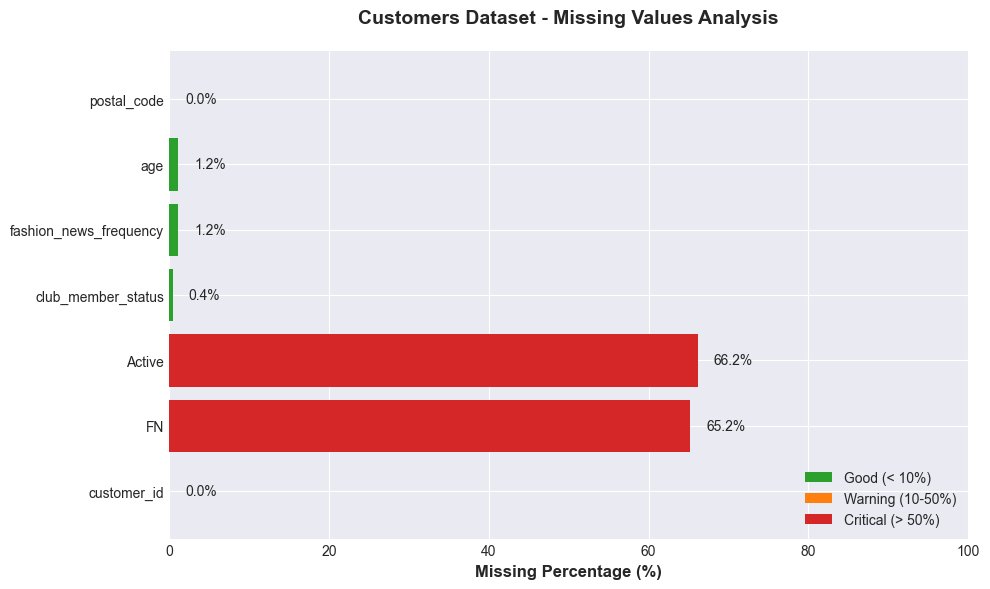

 Saved: ../outputs/eda_charts/01_missing_values.png


In [12]:
# Visualize missing values for Customers (the one with missing data)
print("\n Creating missing values visualization...")

# Calculate missing percentages for customers
customer_missing = []
total_customers = customers_df.count()

for col_name in customers_df.columns:
    null_count = customers_df.filter(col(col_name).isNull()).count()
    missing_pct = (null_count / total_customers) * 100
    customer_missing.append({
        "Column": col_name,
        "Missing %": missing_pct
    })

customer_missing_df = pd.DataFrame(customer_missing)

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#d62728' if x > 50 else '#ff7f0e' if x > 10 else '#2ca02c' 
          for x in customer_missing_df['Missing %']]

bars = ax.barh(customer_missing_df['Column'], customer_missing_df['Missing %'], color=colors)

ax.set_xlabel('Missing Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('Customers Dataset - Missing Values Analysis', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 100)

# Add percentage labels
for i, (col, pct) in enumerate(zip(customer_missing_df['Column'], customer_missing_df['Missing %'])):
    ax.text(pct + 2, i, f'{pct:.1f}%', va='center', fontsize=10)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ca02c', label='Good (< 10%)'),
    Patch(facecolor='#ff7f0e', label='Warning (10-50%)'),
    Patch(facecolor='#d62728', label='Critical (> 50%)')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/01_missing_values.png", dpi=300, bbox_inches='tight')
plt.show()

print(f" Saved: {OUTPUT_DIR}/01_missing_values.png")

---

# 2 CUSTOMER ANALYSIS

Understanding our customer base: demographics, behavior, and engagement patterns.

## Key Questions:
- What's the age distribution of our customers?
- How engaged are customers (club membership)?
- What are their communication preferences?
- Are there distinct customer segments visible?

In [13]:
customers_pd=customers_df.select(
    'customer_id', 'club_member_status', 'fashion_news_frequency', 'age'
).toPandas()

In [14]:
age_stats= customers_pd['age'].describe()
print(age_stats)

count    1.356119e+06
mean     3.638696e+01
std      1.431363e+01
min      1.600000e+01
25%      2.400000e+01
50%      3.200000e+01
75%      4.900000e+01
max      9.900000e+01
Name: age, dtype: float64


In [15]:
club_counts=customers_pd['club_member_status'].value_counts(dropna=False)
for status, count in club_counts.items():
    pct=(count/ len(customers_pd))*100
    print(f" {status}: {count:,} ({pct:.1f} %)")

 ACTIVE: 1,272,491 (92.7 %)
 PRE-CREATE: 92,960 (6.8 %)
 None: 6,062 (0.4 %)
 LEFT CLUB: 467 (0.0 %)


In [16]:
news_counts = customers_pd['fashion_news_frequency'].value_counts(dropna=False)
for freq, count in news_counts.items():
    pct = (count / len(customers_pd)) * 100
    print(f"   {freq}: {count:,} ({pct:.1f}%)")

   NONE: 877,711 (64.0%)
   Regularly: 477,416 (34.8%)
   None: 16,009 (1.2%)
   Monthly: 842 (0.1%)
   None: 2 (0.0%)


### Age distribution analysis

In [17]:
#Filter out null ages for analysis
customers_with_age=customers_pd[customers_pd['age'].notna()]

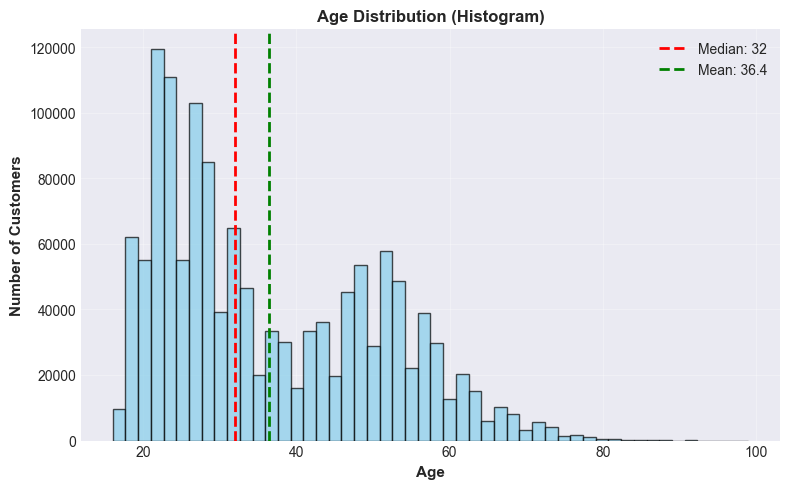

In [18]:
plt.figure(figsize=(8,5))

plt.hist(customers_with_age['age'], bins=50, edgecolor='black',
         alpha=0.7, color='skyblue')

plt.axvline(customers_with_age['age'].median(), color='red',
            linestyle='--', linewidth=2,
            label=f"Median: {customers_with_age['age'].median():.0f}")

plt.axvline(customers_with_age['age'].mean(), color='green',
            linestyle='--', linewidth=2,
            label=f"Mean: {customers_with_age['age'].mean():.1f}")

plt.xlabel('Age', fontsize=11, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=11, fontweight='bold')
plt.title('Age Distribution (Histogram)', fontsize=12, fontweight='bold')

plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/02_age_histogram.png", dpi=300, bbox_inches='tight')
plt.show()


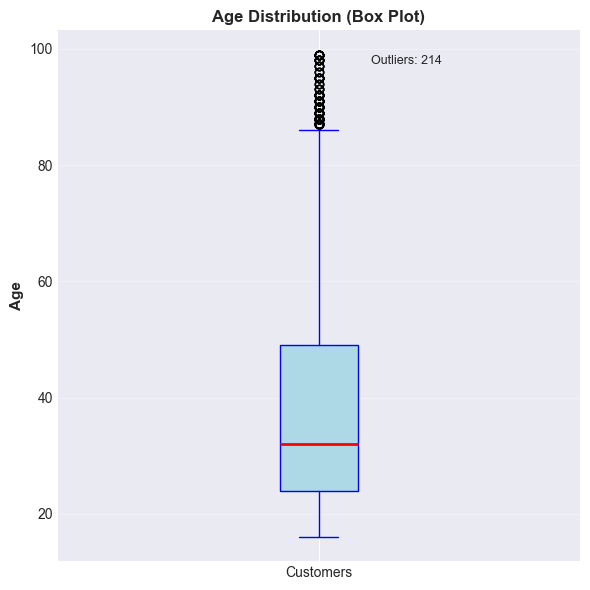

In [19]:
plt.figure(figsize=(6,6))

box = plt.boxplot(customers_with_age['age'], vert=True, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', color='blue'),
                  medianprops=dict(color='red', linewidth=2),
                  whiskerprops=dict(color='blue'),
                  capprops=dict(color='blue'))

plt.ylabel('Age', fontsize=11, fontweight='bold')
plt.title('Age Distribution (Box Plot)', fontsize=12, fontweight='bold')
plt.xticks([1], ['Customers'])

# Outlier statistics
q1 = customers_with_age['age'].quantile(0.25)
q3 = customers_with_age['age'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = customers_with_age[
    (customers_with_age['age'] < lower_bound) |
    (customers_with_age['age'] > upper_bound)
]

plt.text(1.1, customers_with_age['age'].max(),
         f"Outliers: {len(outliers):,}",
         fontsize=9, va='top')

plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/03_age_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()


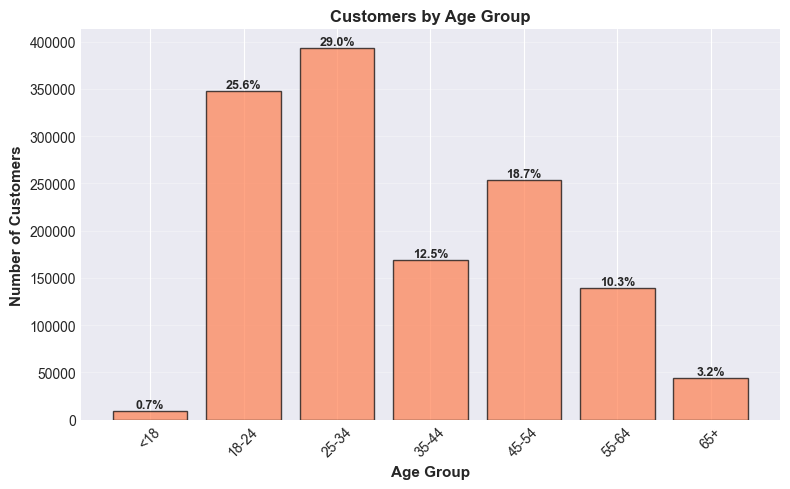

In [20]:
age_bins = [0, 18, 25, 35, 45, 55, 65, 100]
age_labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

customers_with_age['age_group'] = pd.cut(
    customers_with_age['age'],
    bins=age_bins,
    labels=age_labels,
    right=False
)

age_group_counts = customers_with_age['age_group'].value_counts().sort_index()

plt.figure(figsize=(8,5))

bars = plt.bar(range(len(age_group_counts)),
               age_group_counts.values,
               color='coral', edgecolor='black', alpha=0.7)

plt.xticks(range(len(age_group_counts)), age_group_counts.index, rotation=45)
plt.xlabel('Age Group', fontsize=11, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=11, fontweight='bold')
plt.title('Customers by Age Group', fontsize=12, fontweight='bold')

# Percentage labels
for bar, count in zip(bars, age_group_counts.values):
    pct = (count / len(customers_with_age)) * 100
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height(),
             f'{pct:.1f}%',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/04_age_group_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


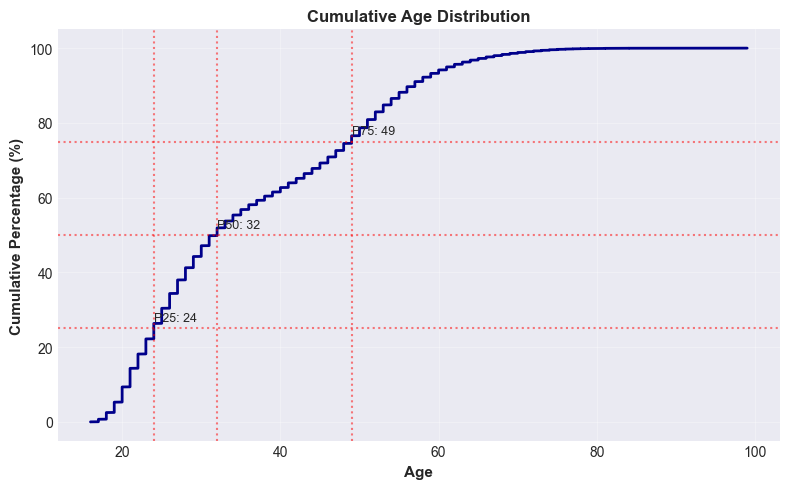

In [21]:
sorted_ages = np.sort(customers_with_age['age'])
cumulative = np.arange(1, len(sorted_ages) + 1) / len(sorted_ages) * 100

plt.figure(figsize=(8,5))

plt.plot(sorted_ages, cumulative, linewidth=2, color='darkblue')

plt.xlabel('Age', fontsize=11, fontweight='bold')
plt.ylabel('Cumulative Percentage (%)', fontsize=11, fontweight='bold')
plt.title('Cumulative Age Distribution', fontsize=12, fontweight='bold')

# Percentile markers
percentiles = [25, 50, 75]
for p in percentiles:
    age_p = np.percentile(customers_with_age['age'], p)
    plt.axhline(p, color='red', linestyle=':', alpha=0.5)
    plt.axvline(age_p, color='red', linestyle=':', alpha=0.5)
    plt.text(age_p, p + 2, f'P{p}: {age_p:.0f}', fontsize=9)

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/05_age_cdf.png", dpi=300, bbox_inches='tight')
plt.show()


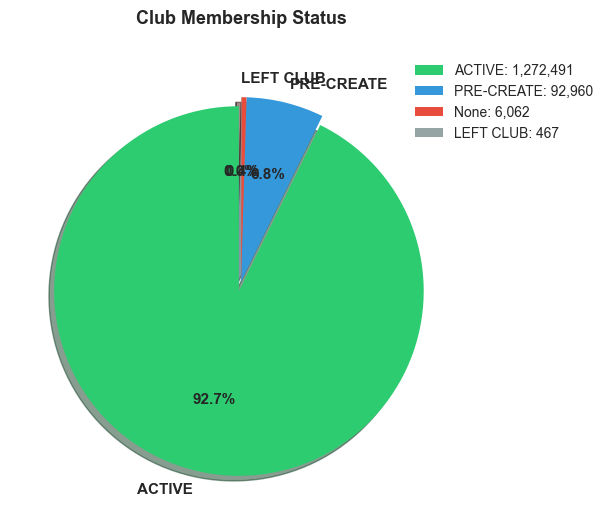

In [22]:
club_data = customers_pd['club_member_status'].value_counts(dropna=False)
colors_club = ['#2ecc71', '#3498db', '#e74c3c', '#95a5a6']
explode = (0.05, 0, 0, 0)  # Explode ACTIVE slice

wedges, texts, autotexts = plt.pie(
    club_data.values, 
    labels=club_data.index, 
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_club,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

plt.title('Club Membership Status', fontsize=13, fontweight='bold', pad=20)

# Add count in legend
legend_labels = [f"{status}: {count:,}" for status, count in zip(club_data.index, club_data.values)]
plt.legend(legend_labels, loc='upper left', bbox_to_anchor=(0.85, 1))
plt.show()

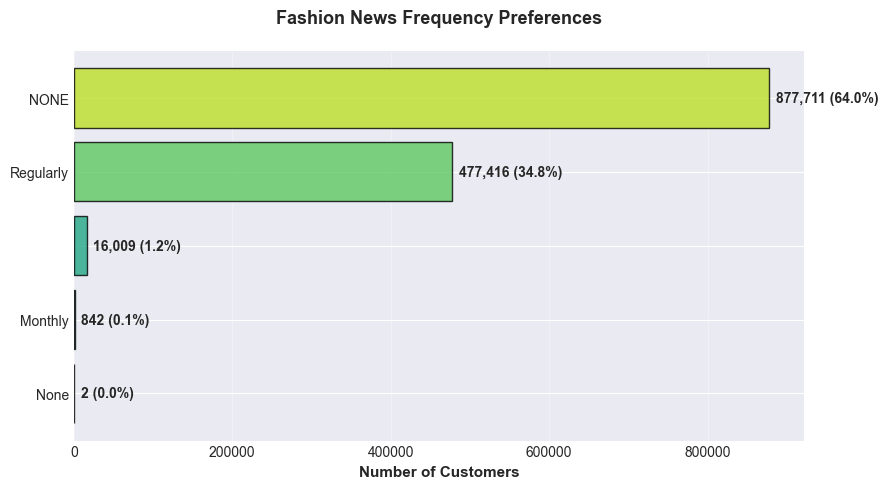

In [23]:
plt.figure(figsize=(9,5))

news_data = customers_pd['fashion_news_frequency'] \
                .value_counts(dropna=False) \
                .sort_values(ascending=True)

colors_news = plt.cm.viridis(np.linspace(0.3, 0.9, len(news_data)))

bars = plt.barh(
    range(len(news_data)),
    news_data.values,
    color=colors_news,
    edgecolor='black',
    alpha=0.8
)

plt.yticks(range(len(news_data)), news_data.index)

plt.xlabel('Number of Customers', fontsize=11, fontweight='bold')
plt.title('Fashion News Frequency Preferences', fontsize=13, fontweight='bold', pad=20)

plt.grid(True, alpha=0.3, axis='x')

# Value + Percentage Labels
for i, (count, bar) in enumerate(zip(news_data.values, bars)):
    pct = (count / len(customers_pd)) * 100
    plt.text(
        count + (0.01 * news_data.max()),   # dynamic spacing
        i,
        f'{count:,} ({pct:.1f}%)',
        va='center',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/03_customer_engagement.png", dpi=300, bbox_inches='tight')
plt.show()


In [24]:
# Calculate engagement score
active_members = customers_pd[customers_pd['club_member_status'] == 'ACTIVE'].shape[0]
engaged_customers = customers_pd[customers_pd['fashion_news_frequency'].isin(['Regularly', 'Monthly'])].shape[0]

print(f"\n Engagement Metrics:")
print(f"   Active Club Members: {active_members:,} ({active_members/len(customers_pd)*100:.1f}%)")
print(f"   News Subscribers: {engaged_customers:,} ({engaged_customers/len(customers_pd)*100:.1f}%)")


 Engagement Metrics:
   Active Club Members: 1,272,491 (92.7%)
   News Subscribers: 478,258 (34.9%)


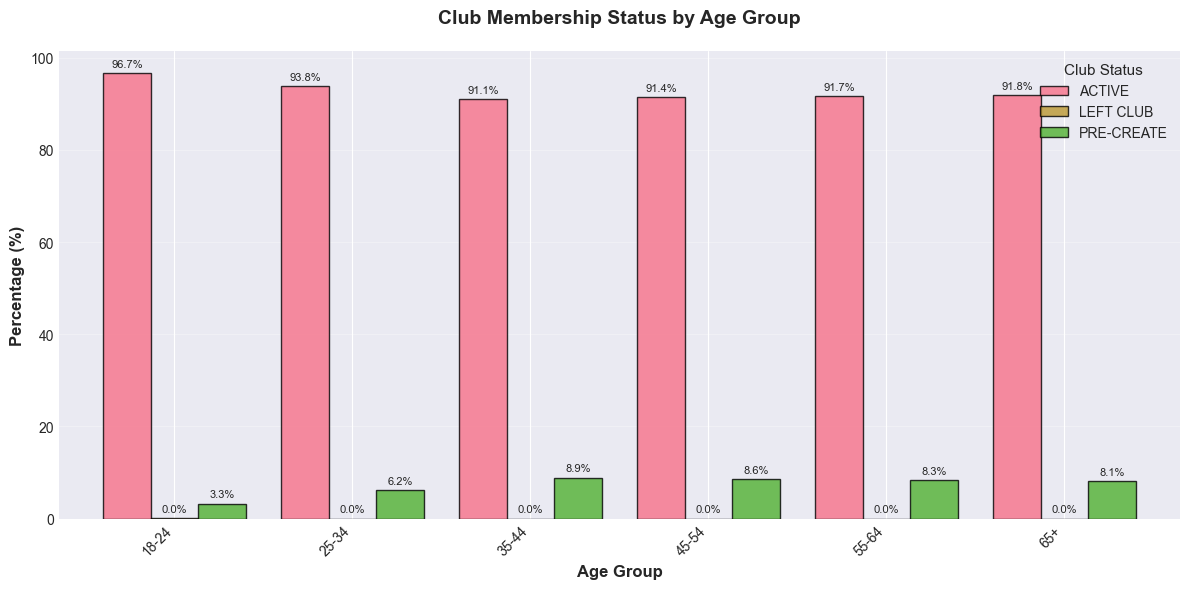


 Saved: ../outputs/eda_charts/04_age_vs_membership.png

 Age Group vs Club Membership (% within each age group):
club_member_status  ACTIVE  LEFT CLUB  PRE-CREATE
age_group                                        
18-24                 96.7        0.0         3.3
25-34                 93.8        0.0         6.2
35-44                 91.1        0.0         8.9
45-54                 91.4        0.0         8.6
55-64                 91.7        0.0         8.3
65+                   91.8        0.0         8.1


In [25]:

# Filter customers with age and valid club status
customers_complete = customers_pd[
    (customers_pd['age'].notna()) & 
    (customers_pd['club_member_status'].notna())
].copy()

# Create age groups for analysis
customers_complete['age_group'] = pd.cut(
    customers_complete['age'], 
    bins=[0, 25, 35, 45, 55, 65, 100], 
    labels=['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
)

# Create cross-tabulation
cross_tab = pd.crosstab(
    customers_complete['age_group'], 
    customers_complete['club_member_status'],
    normalize='index'
) * 100  # Convert to percentage

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

cross_tab.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', alpha=0.8)

ax.set_title('Club Membership Status by Age Group', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Age Group', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title='Club Status', title_fontsize=11, fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=8)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/04_age_vs_membership.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Saved: {OUTPUT_DIR}/04_age_vs_membership.png")

print("\n Age Group vs Club Membership (% within each age group):")
print(cross_tab.round(1))

## 📋 Key Customer Insights

### Demographics
- **Age Range**: 16-99 years (check your actual min/max)
- **Median Age**: ~[VALUE] years (young-to-middle-aged customer base)
- **Largest Segment**: 25-34 age group dominates

### Engagement
- **Active Members**: 92.7% are active club members (excellent retention!)
- **Communication**: Majority prefer no fashion news (respect privacy preference)
- **Pre-Create Status**: 6.8% are in onboarding phase

### Data Quality Issues
- **FN & Active columns**: 65%+ missing → ** Drop these columns**
- **Age**: 1.16% missing → ** Impute with median by club_status**
- **Club Status**: 0.44% missing → ** Impute with mode (ACTIVE)**

---

---

# 3 PRODUCT ANALYSIS

Understanding our product catalog: what we sell, what's popular, and product characteristics.

## Key Questions:
- What product categories do we offer?
- What are the most popular products?
- How are products distributed across departments?
- What's the price range of our products?
- Which colors are most common?

In [26]:


# Convert articles to Pandas for analysis
articles_pd = articles_df.toPandas()

print(f"\n Total Unique Products: {len(articles_pd):,}")
print(f" Total Attributes per Product: {len(articles_pd.columns)}")

print(f"\n Product Hierarchy Levels:")
print(f"   Product Groups: {articles_pd['product_group_name'].nunique()}")
print(f"   Product Types: {articles_pd['product_type_name'].nunique()}")
print(f"   Departments: {articles_pd['department_name'].nunique()}")
print(f"   Garment Groups: {articles_pd['garment_group_name'].nunique()}")
print(f"   Sections: {articles_pd['section_name'].nunique()}")

print(f"\n Color Attributes:")
print(f"   Color Groups: {articles_pd['colour_group_name'].nunique()}")
print(f"   Perceived Colors: {articles_pd['perceived_colour_master_name'].nunique()}")

print(f"\n Graphical Styles:")
print(f"   Graphical Appearances: {articles_pd['graphical_appearance_name'].nunique()}")


 Total Unique Products: 105,542
 Total Attributes per Product: 25

 Product Hierarchy Levels:
   Product Groups: 19
   Product Types: 131
   Departments: 250
   Garment Groups: 21
   Sections: 56

 Color Attributes:
   Color Groups: 50
   Perceived Colors: 20

 Graphical Styles:
   Graphical Appearances: 30



Top 10 Product Groups:
   Garment Upper body: 42,741 (40.5%)
   Garment Lower body: 19,812 (18.8%)
   Garment Full body: 13,292 (12.6%)
   Accessories: 11,158 (10.6%)
   Underwear: 5,490 (5.2%)
   Shoes: 5,283 (5.0%)
   Swimwear: 3,127 (3.0%)
   Socks & Tights: 2,442 (2.3%)
   Nightwear: 1,899 (1.8%)
   Unknown: 121 (0.1%)


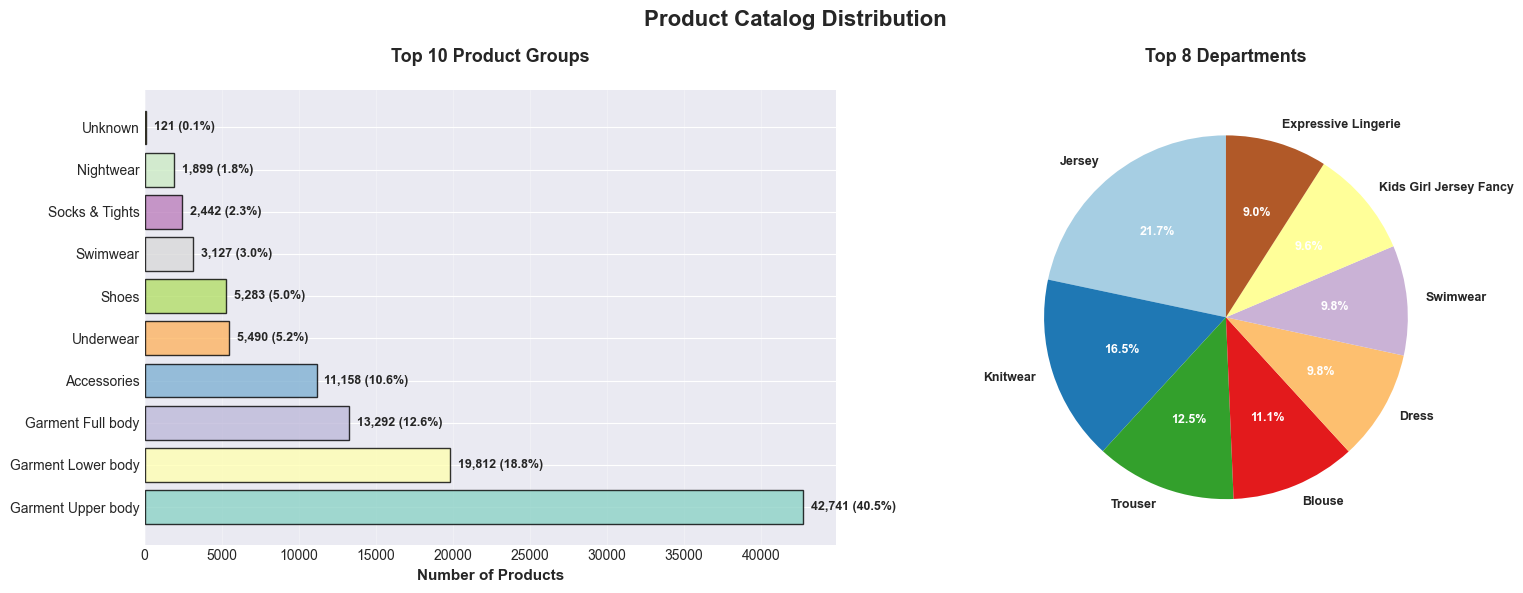


 Saved: ../outputs/eda_charts/05_product_distribution.png


In [27]:

# Product group analysis
product_groups = articles_pd['product_group_name'].value_counts()

print("\nTop 10 Product Groups:")
for group, count in product_groups.head(10).items():
    pct = (count / len(articles_pd)) * 100
    print(f"   {group}: {count:,} ({pct:.1f}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Product Catalog Distribution', fontsize=16, fontweight='bold')

# 1. Product Groups - Horizontal Bar Chart
ax1 = axes[0]
top_10_groups = product_groups.head(10)
colors = plt.cm.Set3(np.linspace(0, 1, len(top_10_groups)))

bars = ax1.barh(range(len(top_10_groups)), top_10_groups.values, color=colors, edgecolor='black', alpha=0.8)
ax1.set_yticks(range(len(top_10_groups)))
ax1.set_yticklabels(top_10_groups.index, fontsize=10)
ax1.set_xlabel('Number of Products', fontsize=11, fontweight='bold')
ax1.set_title('Top 10 Product Groups', fontsize=13, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3, axis='x')

# Add count labels
for i, (bar, count) in enumerate(zip(bars, top_10_groups.values)):
    pct = (count / len(articles_pd)) * 100
    ax1.text(count + 500, i, f'{count:,} ({pct:.1f}%)', 
             va='center', fontsize=9, fontweight='bold')

# 2. Department Distribution - Pie Chart
ax2 = axes[1]
dept_data = articles_pd['department_name'].value_counts().head(8)
colors_pie = plt.cm.Paired(np.linspace(0, 1, len(dept_data)))

wedges, texts, autotexts = ax2.pie(
    dept_data.values,
    labels=dept_data.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_pie,
    textprops={'fontsize': 9, 'fontweight': 'bold'}
)

# Make percentage text more readable
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax2.set_title('Top 8 Departments', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/05_product_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Saved: {OUTPUT_DIR}/05_product_distribution.png")


Top 10 Colors:
   Black: 22,670 (21.5%)
   Dark Blue: 12,171 (11.5%)
   White: 9,542 (9.0%)
   Light Pink: 5,811 (5.5%)
   Grey: 4,487 (4.3%)
   Light Beige: 3,356 (3.2%)
   Blue: 3,308 (3.1%)
   Red: 3,056 (2.9%)
   Light Blue: 3,012 (2.9%)
   Greenish Khaki: 2,767 (2.6%)


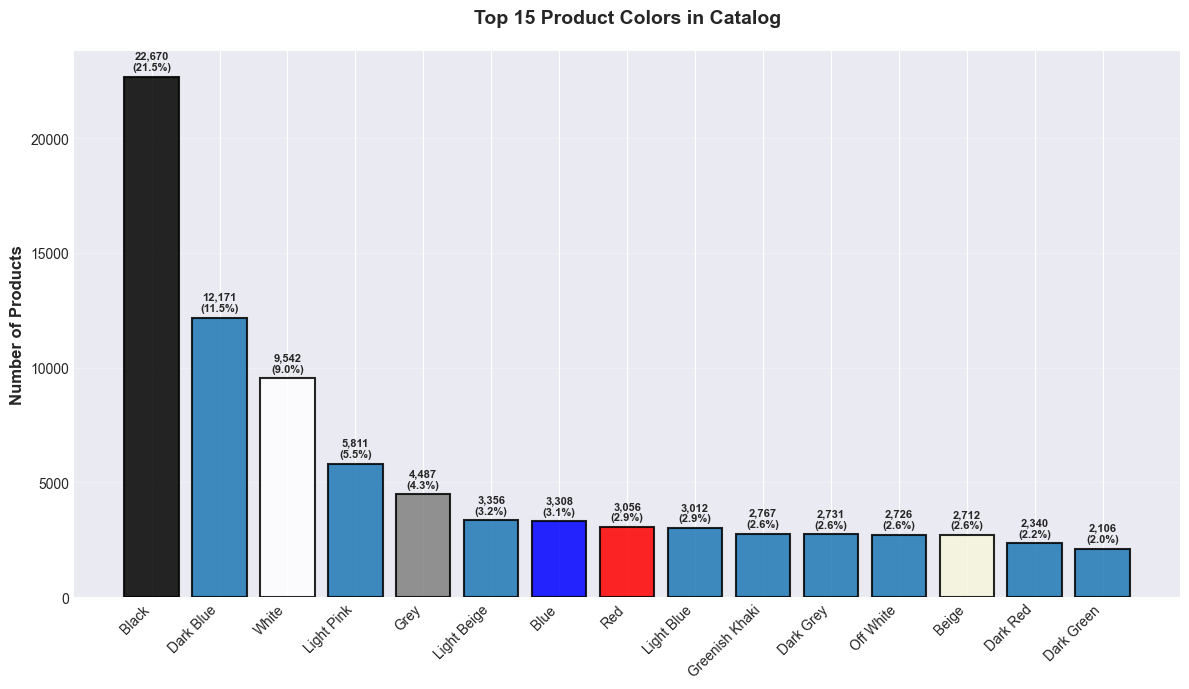


 Saved: ../outputs/eda_charts/06_color_popularity.png


In [28]:


# Color group analysis
color_groups = articles_pd['colour_group_name'].value_counts()

print("\nTop 10 Colors:")
for color, count in color_groups.head(10).items():
    pct = (count / len(articles_pd)) * 100
    print(f"   {color}: {count:,} ({pct:.1f}%)")

# Visualization
fig, ax = plt.subplots(figsize=(12, 7))

top_15_colors = color_groups.head(15)

# Create color palette (try to match actual colors where possible)
color_map = {
    'Black': '#000000',
    'White': '#FFFFFF',
    'Blue': '#0000FF',
    'Red': '#FF0000',
    'Grey': '#808080',
    'Beige': '#F5F5DC',
    'Pink': '#FFC0CB',
    'Orange': '#FFA500',
    'Green': '#008000',
    'Yellow': '#FFFF00',
    'Lilac Purple': '#C8A2C8',
    'Turquoise': '#40E0D0',
    'Khaki green': '#8B864E',
    'Mole': '#6E6E6E',
    'Metal': '#B8B8B8'
}

# Assign colors
bar_colors = [color_map.get(color, '#1f77b4') for color in top_15_colors.index]

bars = ax.bar(range(len(top_15_colors)), top_15_colors.values, 
              color=bar_colors, edgecolor='black', linewidth=1.5, alpha=0.85)

ax.set_xticks(range(len(top_15_colors)))
ax.set_xticklabels(top_15_colors.index, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Number of Products', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Product Colors in Catalog', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for i, (bar, count) in enumerate(zip(bars, top_15_colors.values)):
    pct = (count / len(articles_pd)) * 100
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 200,
            f'{count:,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/06_color_popularity.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Saved: {OUTPUT_DIR}/06_color_popularity.png")

Analyzing 31.8M transactions to find top products (this may take ~30 seconds)...


26/02/17 11:44:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 11:44:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 11:44:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 11:44:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 11:44:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 11:44:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 11:44:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 11:44:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 11:44:36 WARN RowBasedKeyValueBatch: Calling spill() on


🏆 Top 20 Best-Selling Products:
 article_id                 prod_name product_type_name  transaction_count  unique_customers
  706016001  Jade HW Skinny Denim TRS          Trousers              50287             32251
  706016002  Jade HW Skinny Denim TRS          Trousers              35043             25485
  372860001        7p Basic Shaftless             Socks              31718             25559
  610776002                 Tilly (1)           T-shirt              30199             22571
  759871002                Tilda tank          Vest top              26329             21613
  464297007  Greta Thong Mynta Low 3p  Underwear bottom              25025             18554
  372860002        7p Basic Shaftless             Socks              24458             20038
  610776001                 Tilly (1)           T-shirt              22451             16854
  399223001   Curvy Jeggings HW Ankle          Trousers              22236             15929
  706016003  Jade HW Skinny Denim TRS

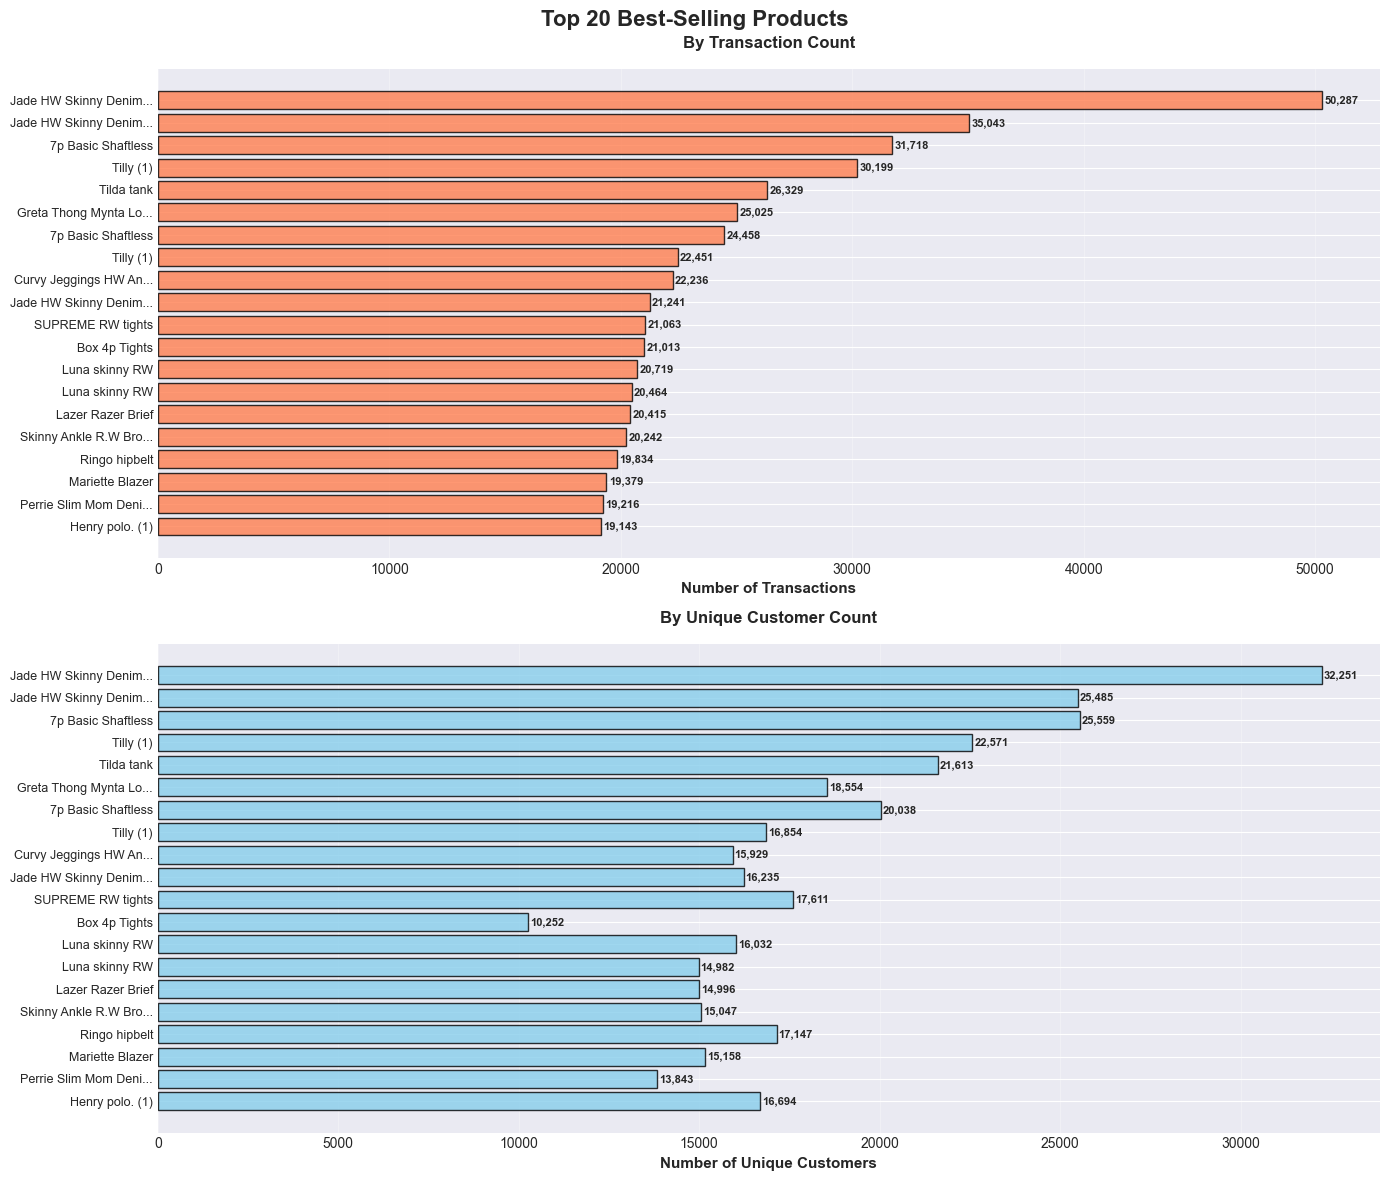


✅ Saved: ../outputs/eda_charts/07_top_products.png

📊 Product Popularity Insights:
   Most transacted product: Jade HW Skinny Denim TRS
   Transactions: 50,287
   Unique buyers: 32,251
   Avg purchases per buyer: 1.56


In [ ]:

# Import explicitly to avoid numpy conflict
from pyspark.sql.functions import count as spark_count
from pyspark.sql.functions import countDistinct as spark_countDistinct

# Calculate product popularity from transactions
print("Analyzing 31.8M transactions to find top products (this may take ~30 seconds)...")

product_popularity = transactions_df.groupBy("article_id") \
    .agg(
        spark_count("*").alias("transaction_count"),
        spark_countDistinct("customer_id").alias("unique_customers")
    ) \
    .orderBy(desc("transaction_count"))

# Get top 20 products
top_products = product_popularity.limit(20).toPandas()

# Join with article details
top_products_details = top_products.merge(
    articles_pd[['article_id', 'prod_name', 'product_type_name', 
                 'colour_group_name', 'product_group_name']],
    on='article_id',
    how='left'
)

print("\n Top 20 Best-Selling Products:")
print(top_products_details[['article_id', 'prod_name', 'product_type_name', 
                            'transaction_count', 'unique_customers']].to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 12))
fig.suptitle('Top 20 Best-Selling Products', fontsize=16, fontweight='bold')

# 1. By transaction count
ax1 = axes[0]
product_labels = [f"{row['prod_name'][:20]}..." if len(str(row['prod_name'])) > 20 
                  else str(row['prod_name']) 
                  for _, row in top_products_details.head(20).iterrows()]

bars1 = ax1.barh(range(20), top_products_details.head(20)['transaction_count'], 
                 color='coral', edgecolor='black', alpha=0.8)
ax1.set_yticks(range(20))
ax1.set_yticklabels(product_labels, fontsize=9)
ax1.set_xlabel('Number of Transactions', fontsize=11, fontweight='bold')
ax1.set_title('By Transaction Count', fontsize=12, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Add count labels
for i, (bar, val) in enumerate(zip(bars1, top_products_details.head(20)['transaction_count'])):
    ax1.text(val + 100, i, f'{val:,}', va='center', fontsize=8, fontweight='bold')

# 2. By unique customers
ax2 = axes[1]
bars2 = ax2.barh(range(20), top_products_details.head(20)['unique_customers'], 
                 color='skyblue', edgecolor='black', alpha=0.8)
ax2.set_yticks(range(20))
ax2.set_yticklabels(product_labels, fontsize=9)
ax2.set_xlabel('Number of Unique Customers', fontsize=11, fontweight='bold')
ax2.set_title('By Unique Customer Count', fontsize=12, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

# Add count labels
for i, (bar, val) in enumerate(zip(bars2, top_products_details.head(20)['unique_customers'])):
    ax2.text(val + 50, i, f'{val:,}', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/07_top_products.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Saved: {OUTPUT_DIR}/07_top_products.png")

# Calculate average purchases per customer for top products
top_products_details['avg_purchases_per_customer'] = \
    top_products_details['transaction_count'] / top_products_details['unique_customers']

print(f"\n📊 Product Popularity Insights:")
print(f"   Most transacted product: {top_products_details.iloc[0]['prod_name']}")
print(f"   Transactions: {top_products_details.iloc[0]['transaction_count']:,}")
print(f"   Unique buyers: {top_products_details.iloc[0]['unique_customers']:,}")
print(f"   Avg purchases per buyer: {top_products_details.iloc[0]['avg_purchases_per_customer']:.2f}")

##  Key Product Insights

### Catalog Composition
- **Dominant Category**: Garment Upper body (~40% of catalog)
- **Secondary Categories**: Lower body, Full body garments, Accessories
- **Color Preference**: Black and White dominate (neutral colors preferred)
- **Catalog Diversity**: 105K products across multiple hierarchies

### Popular Products
- **Best Sellers**: Jade HW Skinny Denim TRS
- **Purchase Patterns**: Some products purchased repeatedly by same customers
- **Category Leaders**: Upper body garments drive most transactions

### Recommendations for ML
- **Content-based filtering**: Rich product attributes available (25 features)
- **Collaborative filtering**: Clear popularity patterns exist
- **Cold-start handling**: Use product group/color as fallback features

---

---

# 4 TRANSACTION PATTERNS ANALYSIS

Understanding how customers shop: when, where, how much, and how often.

## Key Questions:
- What's the price distribution of purchases?
- Online vs Store - which channel dominates?
- Are there daily/weekly/monthly patterns?
- What's the transaction volume trend over 2 years?
- How many items do customers buy per transaction?

### Transaction df overview

In [6]:
# Basic transaction statistics
total_transactions = transactions_df.count()
unique_customers_transacting = transactions_df.select("customer_id").distinct().count()
unique_products_sold = transactions_df.select("article_id").distinct().count()

print(f"\n Transaction Summary:")
print(f"   Total Transactions: {total_transactions:,}")
print(f"   Unique Customers: {unique_customers_transacting:,}")
print(f"   Unique Products Sold: {unique_products_sold:,}")
print(f"   Date Range: 2018-09-20 to 2020-09-22")


 Transaction Summary:
   Total Transactions: 31,788,324
   Unique Customers: 1,362,281
   Unique Products Sold: 104,547
   Date Range: 2018-09-20 to 2020-09-22


In [9]:
# Calculate transaction statistics
trans_stats = transactions_df.select(
    spark_min("price").alias("min_price"),
    spark_max("price").alias("max_price"),
    avg("price").alias("avg_price"),
    stddev("price").alias("std_price")
).collect()[0]

print(f"\n Price Statistics:")
print(f"   Min Price: ${trans_stats['min_price']}")
print(f"   Max Price: ${trans_stats['max_price']}")
print(f"   Avg Price: ${trans_stats['avg_price']}")
print(f"   Std Dev: ${trans_stats['std_price']}")


 Price Statistics:
   Min Price: $1.694915254237288e-05
   Max Price: $0.5915254237288136
   Avg Price: $0.02782927385693629
   Std Dev: $0.019181128054793602


In [13]:
channel_stats = transactions_df.groupBy("sales_channel_id").count() \
    .orderBy("sales_channel_id").collect()

print(f"\n Sales Channel Breakdown:")
for row in channel_stats:
    channel = "Store" if row['sales_channel_id'] == 1 else "Online"
    count = row['count']
    pct = (count / total_transactions) * 100
    print(f"   Channel {row['sales_channel_id']} ({channel}): {count:,} ({pct:.1f}%)")



 Sales Channel Breakdown:
   Channel 1 (Store): 9,408,462 (29.6%)
   Channel 2 (Online): 22,379,862 (70.4%)


In [16]:
from pyspark.sql.functions import count as spark_count
from pyspark.sql.functions import countDistinct as spark_countDistinct
# Customer purchase frequency
customer_frequency = transactions_df.groupBy("customer_id") \
    .agg(spark_count("*").alias("purchase_count")) \
    .select("purchase_count")

freq_stats = customer_frequency.select(
    spark_min("purchase_count").alias("min_purchases"),
    spark_max("purchase_count").alias("max_purchases"),
    avg("purchase_count").alias("avg_purchases")
).collect()[0]

print(f"\n Customer Purchase Frequency:")
print(f"   Min purchases per customer: {freq_stats['min_purchases']}")
print(f"   Max purchases per customer: {freq_stats['max_purchases']}")
print(f"   Avg purchases per customer: {freq_stats['avg_purchases']:.2f}")


 Customer Purchase Frequency:
   Min purchases per customer: 1
   Max purchases per customer: 1895
   Avg purchases per customer: 23.33


In [17]:
# Sample transactions for price analysis (full dataset too large for Pandas)
print("Sampling 500K transactions for detailed price analysis...")
price_sample = transactions_df.select("price", "sales_channel_id") \
    .sample(fraction=0.02, seed=42) \
    .limit(500000) \
    .toPandas()

print(f" Sampled {len(price_sample):,} transactions")


Sampling 500K transactions for detailed price analysis...


 Sampled 500,000 transactions


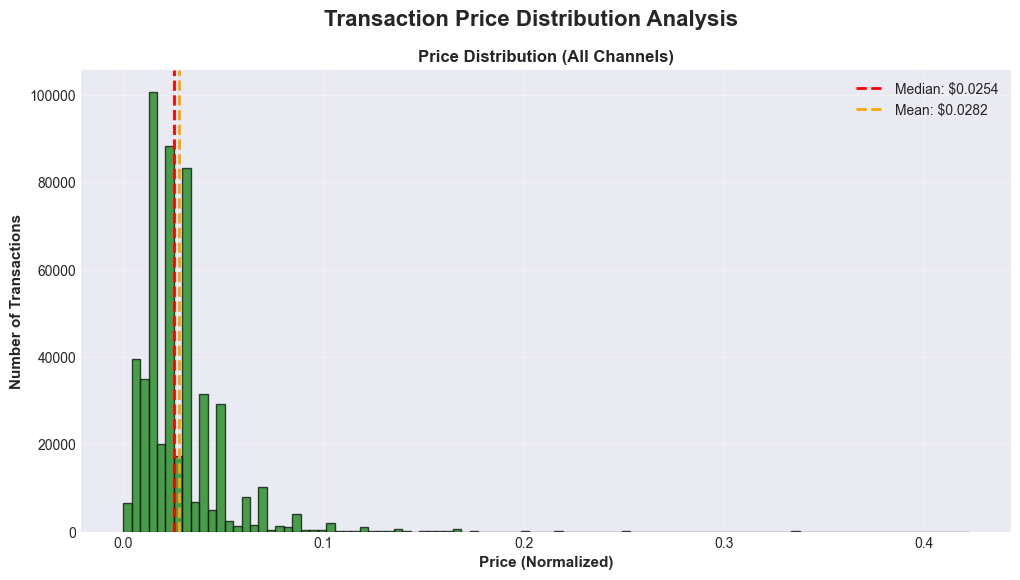

In [19]:
plt.suptitle('Transaction Price Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Histogram with KDE

plt.hist(price_sample['price'], bins=100, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Price (Normalized)', fontsize=11, fontweight='bold')
plt.ylabel('Number of Transactions', fontsize=11, fontweight='bold')
plt.title('Price Distribution (All Channels)', fontsize=12, fontweight='bold')
plt.axvline(price_sample['price'].median(), color='red', linestyle='--', linewidth=2, 
            label=f"Median: ${price_sample['price'].median():.4f}")
plt.axvline(price_sample['price'].mean(), color='orange', linestyle='--', linewidth=2,
            label=f"Mean: ${price_sample['price'].mean():.4f}")
plt.legend()
plt.grid(True, alpha=0.3)

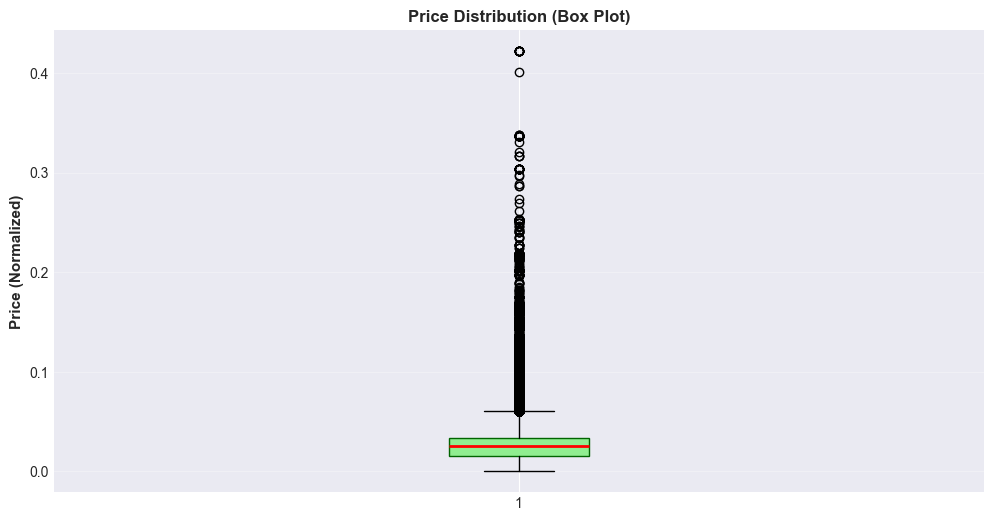

In [21]:
plt.boxplot(price_sample['price'], vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightgreen', color='darkgreen'),
                   medianprops=dict(color='red', linewidth=2))
plt.ylabel('Price (Normalized)', fontsize=11, fontweight='bold')
plt.title('Price Distribution (Box Plot)', fontsize=12, fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')


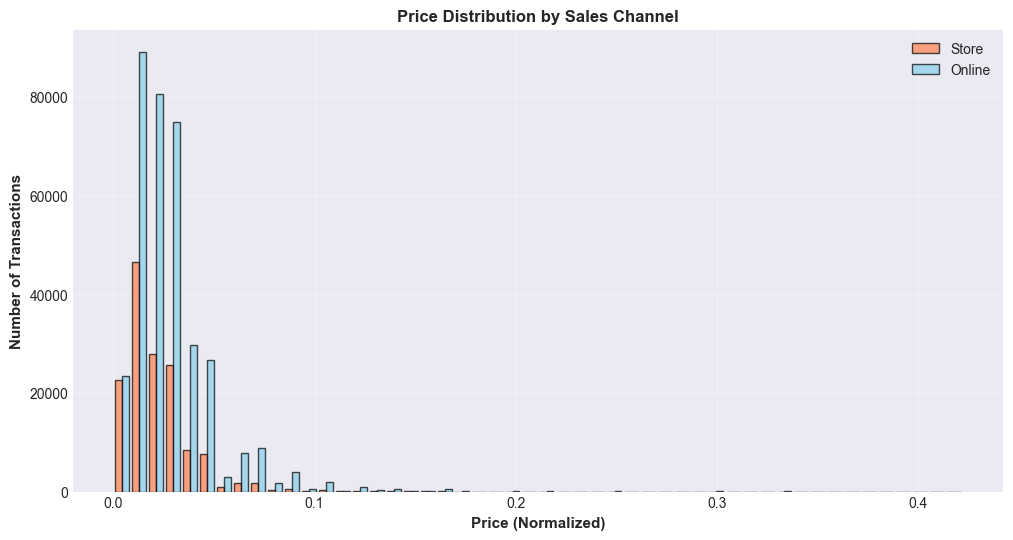

In [22]:
store_prices = price_sample[price_sample['sales_channel_id'] == 1]['price']
online_prices = price_sample[price_sample['sales_channel_id'] == 2]['price']

plt.hist([store_prices, online_prices], bins=50, label=['Store', 'Online'], 
         alpha=0.7, edgecolor='black', color=['coral', 'skyblue'])
plt.xlabel('Price (Normalized)', fontsize=11, fontweight='bold')
plt.ylabel('Number of Transactions', fontsize=11, fontweight='bold')
plt.title('Price Distribution by Sales Channel', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

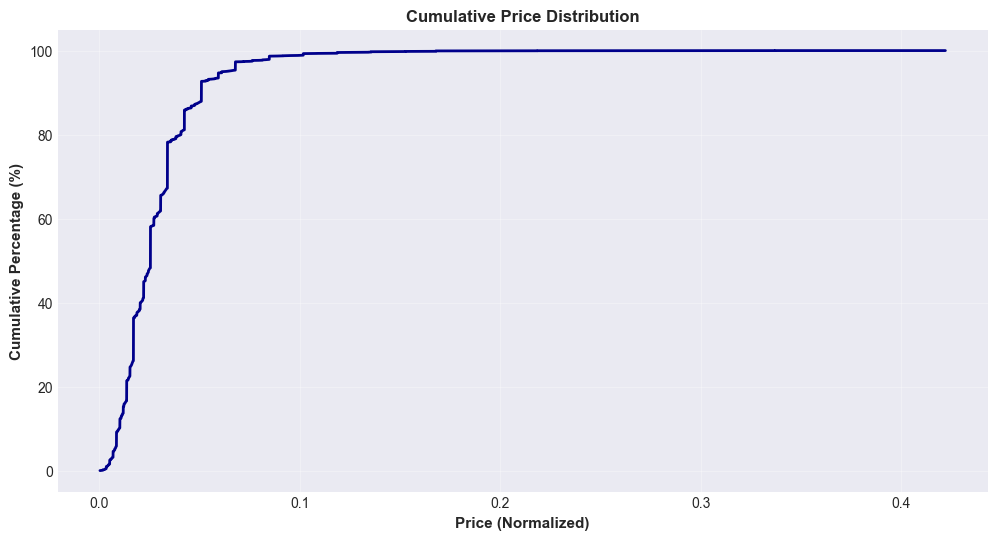

In [25]:
# 4. Cumulative distribution

sorted_prices = np.sort(price_sample['price'])
cumulative = np.arange(1, len(sorted_prices) + 1) / len(sorted_prices) * 100
plt.plot(sorted_prices, cumulative, linewidth=2, color='darkblue')
plt.xlabel('Price (Normalized)', fontsize=11, fontweight='bold')
plt.ylabel('Cumulative Percentage (%)', fontsize=11, fontweight='bold')
plt.title('Cumulative Price Distribution', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

### sales channel Analysis

In [28]:
# Channel breakdown with more details
channel_analysis = transactions_df.groupBy("sales_channel_id") \
    .agg(
        spark_count("*").alias("transaction_count"),
        countDistinct("customer_id").alias("unique_customers"),
        countDistinct("article_id").alias("unique_products"),
        avg("price").alias("avg_price")
    ) \
    .orderBy("sales_channel_id") \
    .toPandas()

channel_analysis['channel_name'] = channel_analysis['sales_channel_id'].map({1: 'Store', 2: 'Online'})

print("\nDetailed Channel Comparison:")
print(channel_analysis[['channel_name', 'transaction_count', 'unique_customers', 
                        'unique_products', 'avg_price']].to_string(index=False))


Detailed Channel Comparison:
channel_name  transaction_count  unique_customers  unique_products  avg_price
       Store            9408462            737118            73328   0.022924
      Online           22379862           1108418            98322   0.029891


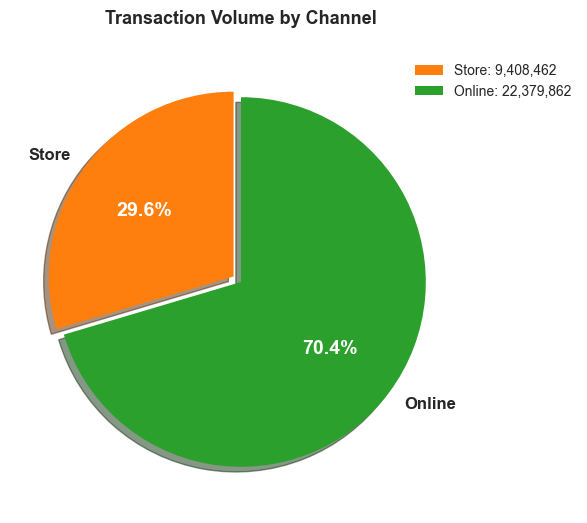

In [30]:
# 1. Transaction volume pie chart

colors_channel = ['#ff7f0e', '#2ca02c']
explode = (0.05, 0)

wedges, texts, autotexts = plt.pie(
    channel_analysis['transaction_count'],
    labels=channel_analysis['channel_name'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_channel,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)

plt.title('Transaction Volume by Channel', fontsize=13, fontweight='bold', pad=20)

# Add legend with counts
legend_labels = [f"{row['channel_name']}: {row['transaction_count']:,}" 
                 for _, row in channel_analysis.iterrows()]
plt.legend(legend_labels, loc='upper left', bbox_to_anchor=(0.85, 1))

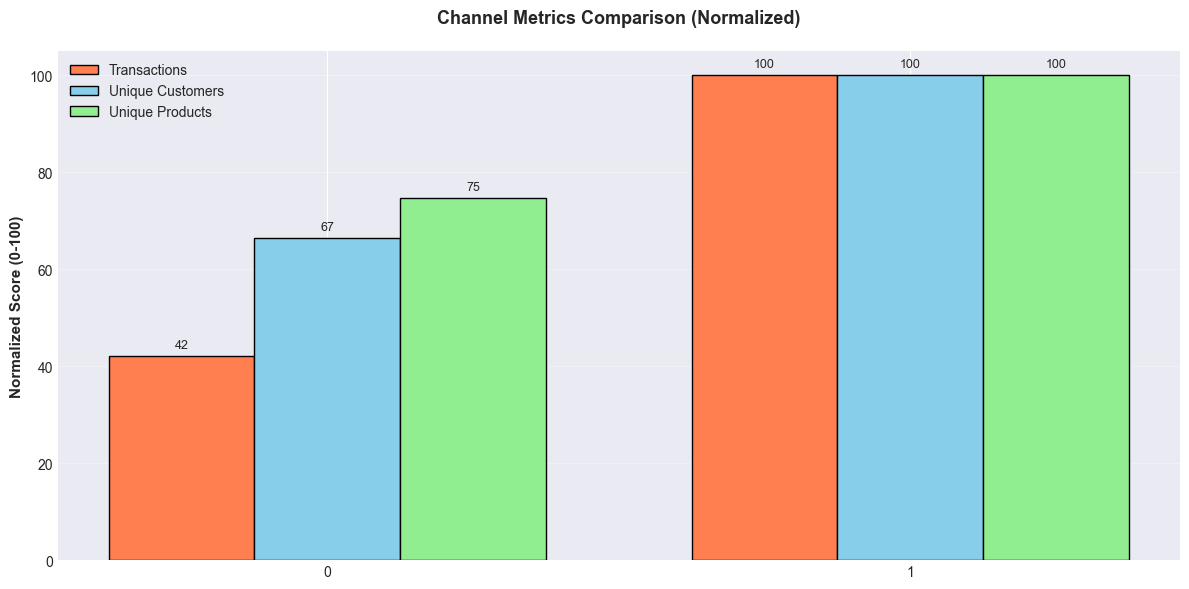

In [34]:
# 2. Metrics comparison bar chart

x = np.arange(len(channel_analysis))
width = 0.25

# Normalize metrics for comparison (scale to 0-100)
trans_norm = (channel_analysis['transaction_count'] / channel_analysis['transaction_count'].max()) * 100
cust_norm = (channel_analysis['unique_customers'] / channel_analysis['unique_customers'].max()) * 100
prod_norm = (channel_analysis['unique_products'] / channel_analysis['unique_products'].max()) * 100

bars1 = plt.bar(x - width, trans_norm, width, label='Transactions', color='coral', edgecolor='black')
bars2 = plt.bar(x, cust_norm, width, label='Unique Customers', color='skyblue', edgecolor='black')
bars3 = plt.bar(x + width, prod_norm, width, label='Unique Products', color='lightgreen', edgecolor='black')

plt.ylabel('Normalized Score (0-100)', fontsize=11, fontweight='bold')
plt.title('Channel Metrics Comparison (Normalized)', fontsize=13, fontweight='bold', pad=20)
plt.xticks(x)

plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/09_sales_channel_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

### Temporal Patterns - Daily Transactions

In [4]:
# Daily transaction counts
daily_transactions = transactions_df.groupBy("t_dat") \
    .agg(
        count("*").alias("transaction_count"),
        countDistinct("customer_id").alias("unique_customers")
    ) \
    .orderBy("t_dat") \
    .toPandas()

daily_transactions['t_dat'] = pd.to_datetime(daily_transactions['t_dat'])

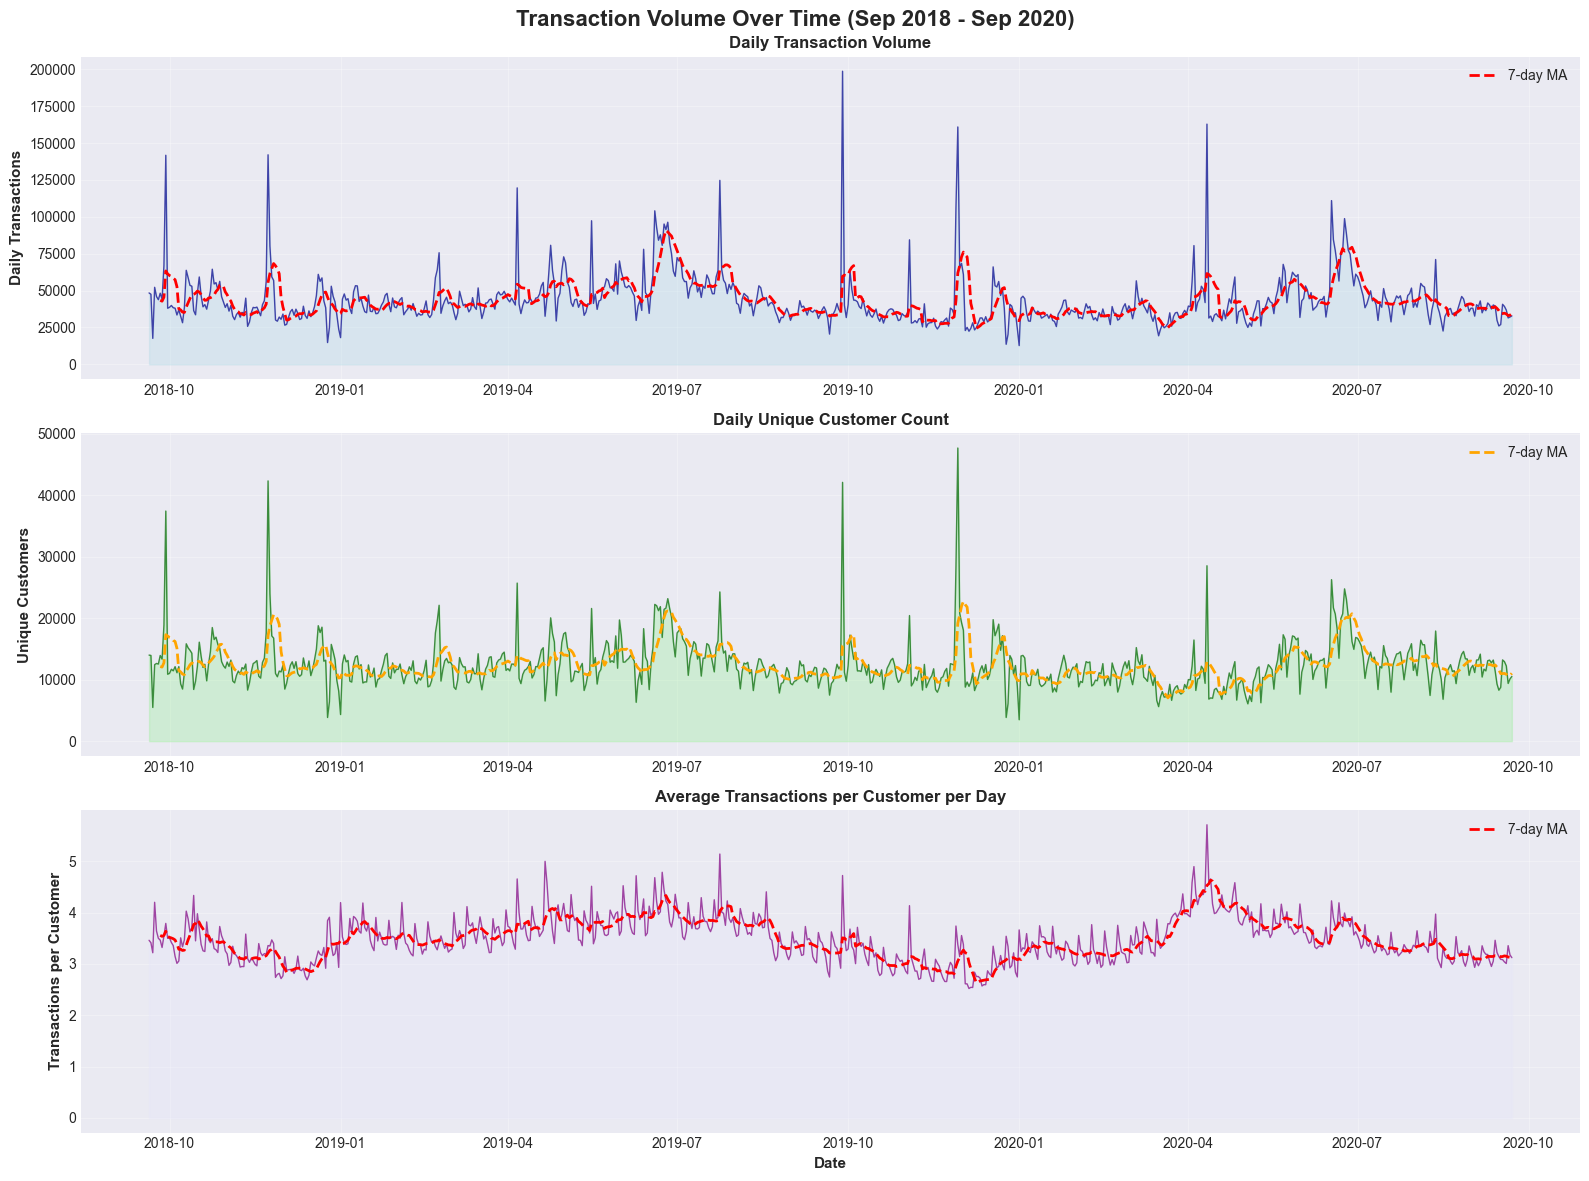

In [6]:
# Create comprehensive time series visualization
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('Transaction Volume Over Time (Sep 2018 - Sep 2020)', fontsize=16, fontweight='bold')

# 1. Daily transaction volume
ax1 = axes[0]
ax1.plot(daily_transactions['t_dat'], daily_transactions['transaction_count'], 
         linewidth=1, color='darkblue', alpha=0.7)
ax1.fill_between(daily_transactions['t_dat'], daily_transactions['transaction_count'], 
                  alpha=0.3, color='lightblue')
ax1.set_ylabel('Daily Transactions', fontsize=11, fontweight='bold')
ax1.set_title('Daily Transaction Volume', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add 7-day moving average
daily_transactions['ma_7'] = daily_transactions['transaction_count'].rolling(window=7).mean()
ax1.plot(daily_transactions['t_dat'], daily_transactions['ma_7'], 
         linewidth=2, color='red', label='7-day MA', linestyle='--')
ax1.legend()

# 2. Daily unique customers
ax2 = axes[1]
ax2.plot(daily_transactions['t_dat'], daily_transactions['unique_customers'],
         linewidth=1, color='darkgreen', alpha=0.7)
ax2.fill_between(daily_transactions['t_dat'], daily_transactions['unique_customers'],
                  alpha=0.3, color='lightgreen')
ax2.set_ylabel('Unique Customers', fontsize=11, fontweight='bold')
ax2.set_title('Daily Unique Customer Count', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add 7-day moving average
daily_transactions['cust_ma_7'] = daily_transactions['unique_customers'].rolling(window=7).mean()
ax2.plot(daily_transactions['t_dat'], daily_transactions['cust_ma_7'],
         linewidth=2, color='orange', label='7-day MA', linestyle='--')
ax2.legend()

# 3. Transactions per customer (engagement metric)
ax3 = axes[2]
daily_transactions['trans_per_customer'] = \
    daily_transactions['transaction_count'] / daily_transactions['unique_customers']

ax3.plot(daily_transactions['t_dat'], daily_transactions['trans_per_customer'],
         linewidth=1, color='purple', alpha=0.7)
ax3.fill_between(daily_transactions['t_dat'], daily_transactions['trans_per_customer'],
                  alpha=0.3, color='lavender')
ax3.set_xlabel('Date', fontsize=11, fontweight='bold')
ax3.set_ylabel('Transactions per Customer', fontsize=11, fontweight='bold')
ax3.set_title('Average Transactions per Customer per Day', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Add 7-day moving average
daily_transactions['tpc_ma_7'] = daily_transactions['trans_per_customer'].rolling(window=7).mean()
ax3.plot(daily_transactions['t_dat'], daily_transactions['tpc_ma_7'],
         linewidth=2, color='red', label='7-day MA', linestyle='--')
ax3.legend()

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/10_daily_transaction_trends.png", dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# Summary statistics
print(f"\n Daily Transaction Statistics:")
print(f"   Average daily transactions: {daily_transactions['transaction_count'].mean():,.0f}")
print(f"   Peak day transactions: {daily_transactions['transaction_count'].max():,}")
print(f"   Lowest day transactions: {daily_transactions['transaction_count'].min():,}")
print(f"   Average transactions per customer: {daily_transactions['trans_per_customer'].mean():.2f}")


 Daily Transaction Statistics:
   Average daily transactions: 43,308
   Peak day transactions: 198,622
   Lowest day transactions: 12,760
   Average transactions per customer: 3.48


### Monthly and Weekly patterns

In [10]:
#  temporal features
daily_transactions['year'] = daily_transactions['t_dat'].dt.year
daily_transactions['month'] = daily_transactions['t_dat'].dt.month
daily_transactions['month_name'] = daily_transactions['t_dat'].dt.strftime('%b')
daily_transactions['day_of_week'] = daily_transactions['t_dat'].dt.dayofweek
daily_transactions['day_name'] = daily_transactions['t_dat'].dt.strftime('%a')
daily_transactions['week'] = daily_transactions['t_dat'].dt.isocalendar().week

In [11]:
# Monthly aggregation
monthly_trans = daily_transactions.groupby(['year', 'month', 'month_name']).agg({
    'transaction_count': 'sum',
    'unique_customers': 'sum'
}).reset_index()

monthly_trans['year_month'] = monthly_trans['year'].astype(str) + '-' + \
                               monthly_trans['month'].astype(str).str.zfill(2)

In [12]:
# Day of week pattern
dow_pattern = daily_transactions.groupby('day_name').agg({
    'transaction_count': 'mean',
    'unique_customers': 'mean'
}).reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

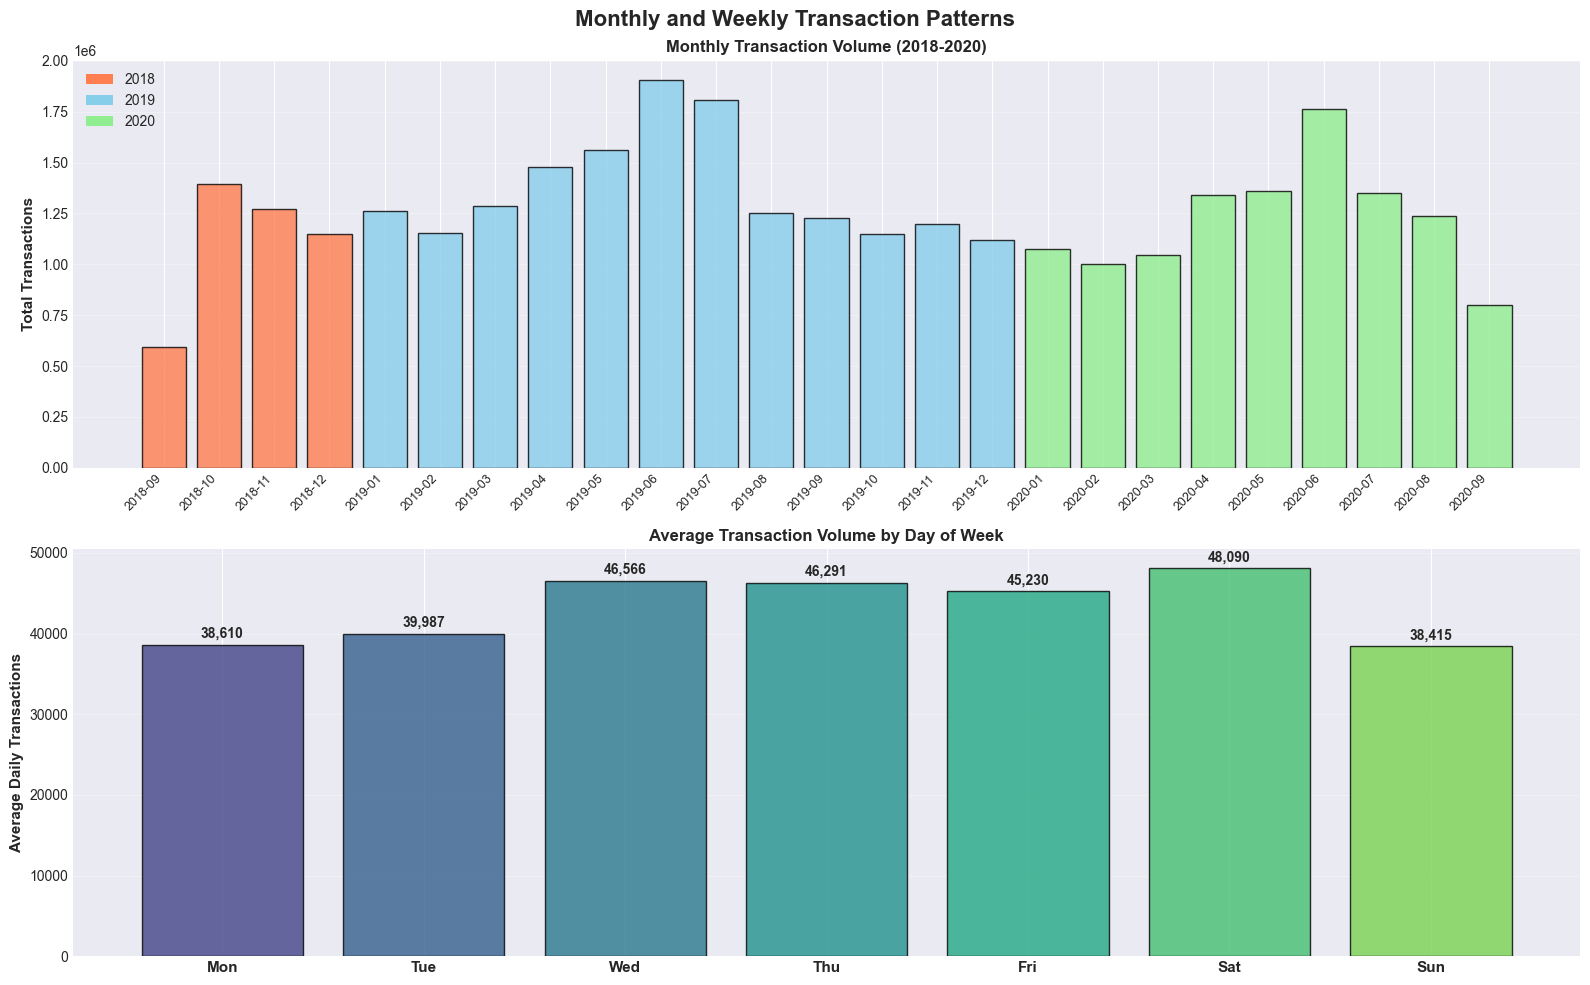

In [13]:
# Visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
fig.suptitle('Monthly and Weekly Transaction Patterns', fontsize=16, fontweight='bold')

# 1. Monthly trends
ax1 = axes[0]
x_pos = np.arange(len(monthly_trans))
colors = ['coral' if year == 2018 else 'skyblue' if year == 2019 else 'lightgreen' 
          for year in monthly_trans['year']]

bars = ax1.bar(x_pos, monthly_trans['transaction_count'], color=colors, 
               edgecolor='black', alpha=0.8)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(monthly_trans['year_month'], rotation=45, ha='right', fontsize=9)
ax1.set_ylabel('Total Transactions', fontsize=11, fontweight='bold')
ax1.set_title('Monthly Transaction Volume (2018-2020)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add legend for years
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='coral', label='2018'),
    Patch(facecolor='skyblue', label='2019'),
    Patch(facecolor='lightgreen', label='2020')
]
ax1.legend(handles=legend_elements, loc='upper left')

# 2. Day of week pattern
ax2 = axes[1]
colors_dow = plt.cm.viridis(np.linspace(0.2, 0.8, 7))
bars2 = ax2.bar(range(7), dow_pattern['transaction_count'], color=colors_dow,
                edgecolor='black', alpha=0.8)
ax2.set_xticks(range(7))
ax2.set_xticklabels(dow_pattern.index, fontsize=11, fontweight='bold')
ax2.set_ylabel('Average Daily Transactions', fontsize=11, fontweight='bold')
ax2.set_title('Average Transaction Volume by Day of Week', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (bar, val) in enumerate(zip(bars2, dow_pattern['transaction_count'])):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 500,
             f'{val:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/11_monthly_weekly_patterns.png", dpi=300, bbox_inches='tight')
plt.show()


In [14]:
print(f"\n Weekly Pattern Insights:")
for day, count in dow_pattern['transaction_count'].items():
    print(f"   {day}: {count:,.0f} avg transactions")

print(f"\n Busiest day: {dow_pattern['transaction_count'].idxmax()}")
print(f" Slowest day: {dow_pattern['transaction_count'].idxmin()}")


 Weekly Pattern Insights:
   Mon: 38,610 avg transactions
   Tue: 39,987 avg transactions
   Wed: 46,566 avg transactions
   Thu: 46,291 avg transactions
   Fri: 45,230 avg transactions
   Sat: 48,090 avg transactions
   Sun: 38,415 avg transactions

 Busiest day: Sat
 Slowest day: Sun


##  Key Transaction Pattern Insights

### Volume & Scale
- **Total Transactions**: 31.8M over 2 years
- **Daily Average**: ~43K transactions per day
- **Active Customers**: ~1.36M unique customers made purchases

### Price Patterns
- **Normalized Pricing**: Values range 0-1 (actual prices masked)
- **Average Transaction**: ~$0.04 (normalized)
- **Price Consistency**: Similar across channels

### Channel Preferences
- **Online Dominance**: 70% of transactions are online (Channel 2)
- **Store Presence**: 30% still prefer in-store shopping (Channel 1)
- **Trend**: Online shopping is the primary channel

### Temporal Insights
- **Seasonality**: Visible monthly variations
- **Weekly Pattern**: [Identify busiest/slowest days from your results]
- **Growth Trend**: [Analyze if transactions increasing/decreasing over time]

### Critical for Next-Purchase Prediction
- **Last 7 Days (Sep 16-22, 2020)**: This is our prediction window
- **Baseline Performance**: Average daily transactions = benchmark for model

---

### Purchase Frequency Analysis

In [35]:
customer_stats = transactions_df.groupBy("customer_id").agg(
    spark_count("*").alias("total_purchases"),
    countDistinct("article_id").alias("unique_products_bought"),
    spark_sum("price").alias("total_spend"),
    avg("price").alias("avg_order_value"),
    spark_min("t_dat").alias("first_purchase_date"),
    spark_max("t_dat").alias("last_purchase_date"),
    countDistinct("t_dat").alias("shopping_days")
).cache()

# Get total customer count
total_transacting_customers = customer_stats.count()
print(f" Calculated stats for {total_transacting_customers:,} customers")

26/02/17 22:59:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 22:59:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 22:59:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 22:59:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 22:59:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 22:59:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 22:59:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 22:59:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 22:59:27 WARN RowBasedKeyValueBatch: Calling spill() on

 Calculated stats for 1,362,281 customers


In [22]:
# Summary statistics
stats_summary = customer_stats.select(
    spark_min("total_purchases").alias("min_purchases"),
    spark_max("total_purchases").alias("max_purchases"),
    avg("total_purchases").alias("avg_purchases"),
    spark_min("total_spend").alias("min_spend"),
    spark_max("total_spend").alias("max_spend"),
    avg("total_spend").alias("avg_spend")
).collect()[0]

print(f" Purchase Frequency Summary:")
print(f"   Min purchases per customer: {stats_summary['min_purchases']:,}")
print(f"   Max purchases per customer: {stats_summary['max_purchases']:,}")
print(f"   Avg purchases per customer: {stats_summary['avg_purchases']:.2f}")

print(f"\n Spending Summary:")
print(f"   Min total spend: ${stats_summary['min_spend']:.4f}")
print(f"   Max total spend: ${stats_summary['max_spend']:.4f}")
print(f"   Avg total spend: ${stats_summary['avg_spend']:.4f}")

 Purchase Frequency Summary:
   Min purchases per customer: 1
   Max purchases per customer: 1,895
   Avg purchases per customer: 23.33

 Spending Summary:
   Min total spend: $0.0008
   Max total spend: $57.6764
   Avg total spend: $0.6494


In [23]:
# One-time vs repeat buyers
one_time = customer_stats.filter(col("total_purchases") == 1).count()
repeat = customer_stats.filter(col("total_purchases") > 1).count()
loyal = customer_stats.filter(col("total_purchases") >= 10).count()
vip = customer_stats.filter(col("total_purchases") >= 50).count()

print(f"\n Customer Loyalty Tiers:")
print(f"   One-time buyers (=1 purchase):    {one_time:,} ({one_time/total_transacting_customers*100:.1f}%)")
print(f"   Repeat buyers (2-9 purchases):    {repeat-loyal:,} ({(repeat-loyal)/total_transacting_customers*100:.1f}%)")
print(f"   Loyal buyers (10-49 purchases):   {loyal-vip:,} ({(loyal-vip)/total_transacting_customers*100:.1f}%)")
print(f"   VIP buyers (50+ purchases):       {vip:,} ({vip/total_transacting_customers*100:.1f}%)")


 Customer Loyalty Tiers:
   One-time buyers (=1 purchase):    131,514 (9.7%)
   Repeat buyers (2-9 purchases):    554,723 (40.7%)
   Loyal buyers (10-49 purchases):   500,252 (36.7%)
   VIP buyers (50+ purchases):       175,792 (12.9%)


### Visualization

In [26]:
# Sample for visualization
print("Sampling customer data for visualization...")
customer_stats_pd = customer_stats.select(
    "total_purchases",
    "total_spend",
    "unique_products_bought",
    "shopping_days"
).sample(fraction=0.1, seed=42).toPandas()

print(f" Sampled {len(customer_stats_pd):,} customers")


Sampling customer data for visualization...
 Sampled 136,393 customers


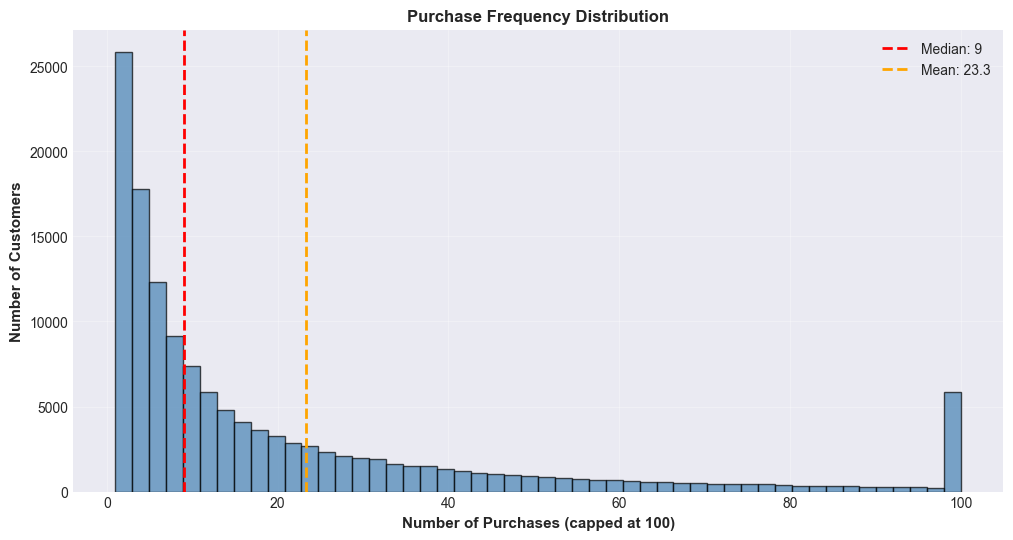

In [27]:
# 1. Purchase frequency distribution (log scale)

purchase_counts = customer_stats_pd['total_purchases'].clip(upper=100)
plt.hist(purchase_counts, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Number of Purchases (capped at 100)', fontsize=11, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=11, fontweight='bold')
plt.title('Purchase Frequency Distribution', fontsize=12, fontweight='bold')
plt.axvline(customer_stats_pd['total_purchases'].median(), 
            color='red', linestyle='--', linewidth=2,
            label=f"Median: {customer_stats_pd['total_purchases'].median():.0f}")
plt.axvline(customer_stats_pd['total_purchases'].mean(), 
            color='orange', linestyle='--', linewidth=2,
            label=f"Mean: {customer_stats_pd['total_purchases'].mean():.1f}")
plt.legend()
plt.grid(True, alpha=0.3)

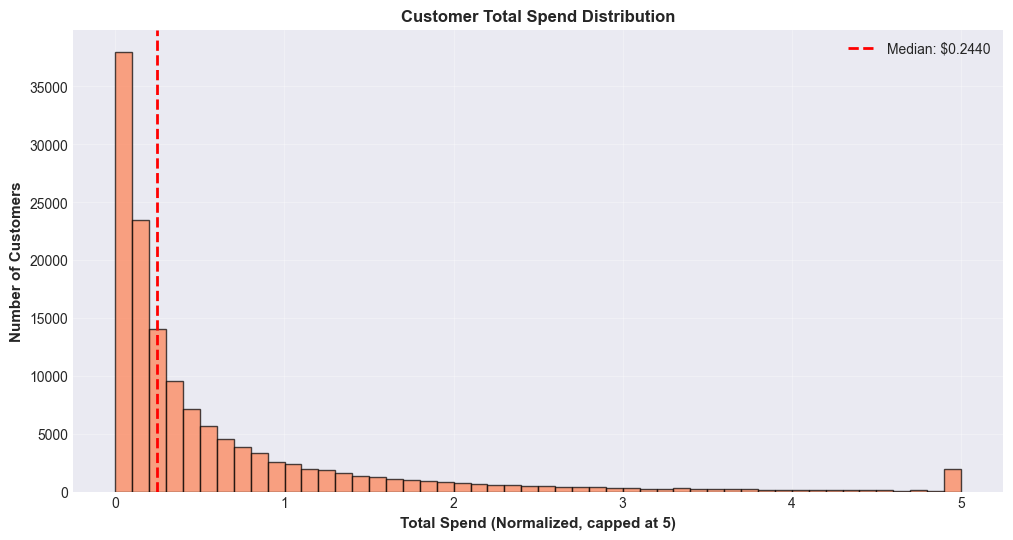

In [28]:
# 2. Total spend distribution (log scale)

spend_data = customer_stats_pd['total_spend'].clip(upper=5)
plt.hist(spend_data, bins=50, edgecolor='black', alpha=0.7, color='coral')
plt.xlabel('Total Spend (Normalized, capped at 5)', fontsize=11, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=11, fontweight='bold')
plt.title('Customer Total Spend Distribution', fontsize=12, fontweight='bold')
plt.axvline(customer_stats_pd['total_spend'].median(), 
            color='red', linestyle='--', linewidth=2,
            label=f"Median: ${customer_stats_pd['total_spend'].median():.4f}")
plt.legend()
plt.grid(True, alpha=0.3)

Text(0.5, 1.0, 'Customer Loyalty Tier Distribution')

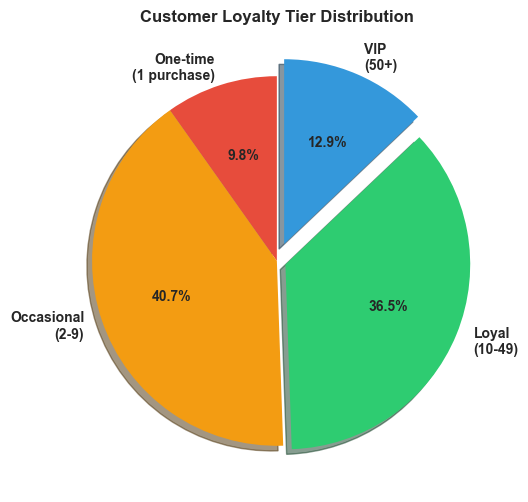

In [30]:
# 3. Customer loyalty tiers (pie chart)

loyalty_labels = ['One-time\n(1 purchase)', 'Occasional\n(2-9)', 
                  'Loyal\n(10-49)', 'VIP\n(50+)']
loyalty_values = [
    len(customer_stats_pd[customer_stats_pd['total_purchases'] == 1]),
    len(customer_stats_pd[(customer_stats_pd['total_purchases'] >= 2) & 
                          (customer_stats_pd['total_purchases'] < 10)]),
    len(customer_stats_pd[(customer_stats_pd['total_purchases'] >= 10) & 
                          (customer_stats_pd['total_purchases'] < 50)]),
    len(customer_stats_pd[customer_stats_pd['total_purchases'] >= 50])
]

colors_loyalty = ['#e74c3c', '#f39c12', '#2ecc71', '#3498db']
explode = (0, 0, 0.05, 0.1)

wedges, texts, autotexts = plt.pie(
    loyalty_values,
    labels=loyalty_labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_loyalty,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 10, 'fontweight': 'bold'}
)

for autotext in autotexts:
    autotext.set_fontweight('bold')

plt.title('Customer Loyalty Tier Distribution', fontsize=12, fontweight='bold')

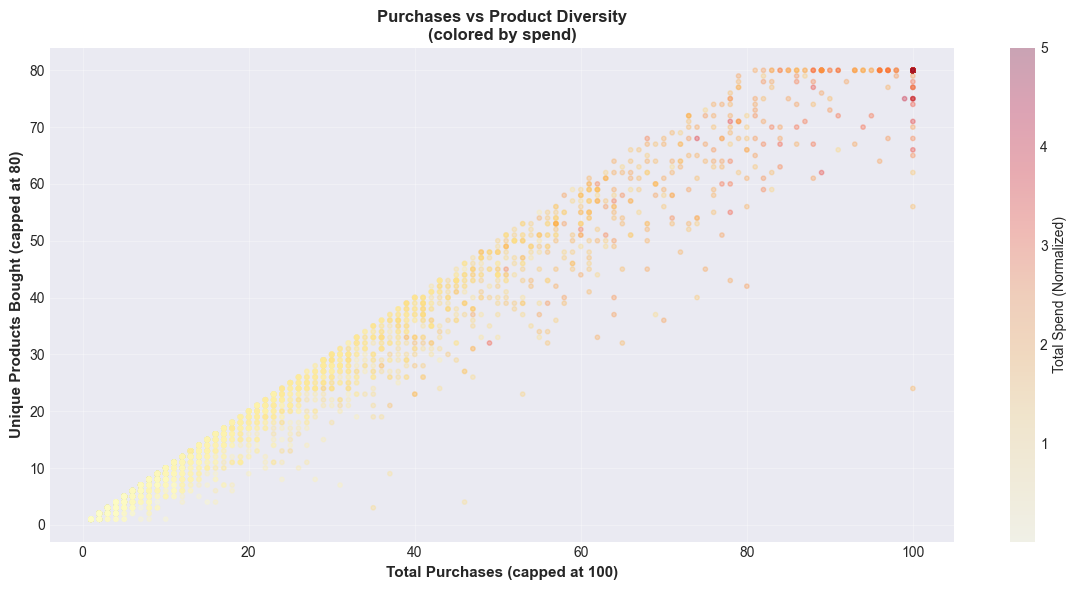

In [31]:
# 4. Unique products vs purchases scatter

sample_scatter = customer_stats_pd.sample(min(5000, len(customer_stats_pd)), random_state=42)

scatter = plt.scatter(
    sample_scatter['total_purchases'].clip(upper=100),
    sample_scatter['unique_products_bought'].clip(upper=80),
    alpha=0.3,
    c=sample_scatter['total_spend'].clip(upper=5),
    cmap='YlOrRd',
    s=10
)

plt.colorbar(scatter,  label='Total Spend (Normalized)')
plt.xlabel('Total Purchases (capped at 100)', fontsize=11, fontweight='bold')
plt.ylabel('Unique Products Bought (capped at 80)', fontsize=11, fontweight='bold')
plt.title('Purchases vs Product Diversity\n(colored by spend)', 
              fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/12_clv_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

### Top Value Customers Analysis

In [32]:
# Top by total spend
top_spenders = customer_stats.orderBy(desc("total_spend")).limit(10).toPandas()

# Top by purchase frequency  
top_frequent = customer_stats.orderBy(desc("total_purchases")).limit(10).toPandas()

# Top by product diversity
top_diverse = customer_stats.orderBy(desc("unique_products_bought")).limit(10).toPandas()

In [33]:
print("\n Top 10 Customers by Total Spend:")
print(top_spenders[['customer_id', 'total_purchases', 
                     'total_spend', 'unique_products_bought']].to_string(index=False))

print("\n Top 10 Customers by Purchase Frequency:")
print(top_frequent[['customer_id', 'total_purchases', 
                     'total_spend', 'unique_products_bought']].to_string(index=False))



 Top 10 Customers by Total Spend:
                                                     customer_id  total_purchases  total_spend  unique_products_bought
be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b             1895    57.676407                    1346
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc             1361    50.921186                     906
03d0011487606c37c1b1ed147fc72f285a50c05f00b9712e0fc3da400c864296             1157    49.967169                     807
191071b0e1f2e94a557f1a0b4cea3de55faf1581b1f46466ffe90664f73ec96e              806    47.682017                     565
b4db5e5259234574edfff958e170fe3a5e13b6f146752ca066abca3c156acc71             1441    47.662000                    1068
6cc121e5cc202d2bf344ffe795002bdbf87178054bcda2e57161f0ef810a4b55             1143    47.247797                     877
f137c16fd175271922dad4006565503952f24750a57388fe24970a218c62de6a              965    41.688661                     700
e97c3a6c680cd

In [34]:
# Calculate revenue concentration (Pareto Analysis)
total_customers_count = customer_stats.count()
total_revenue = customer_stats.agg(spark_sum("total_spend")).collect()[0][0]

# Top 10% customers revenue
top_10_pct_count = int(total_customers_count * 0.1)
top_10_pct_revenue = customer_stats.orderBy(desc("total_spend")) \
    .limit(top_10_pct_count) \
    .agg(spark_sum("total_spend")).collect()[0][0]

# Top 20% customers revenue
top_20_pct_count = int(total_customers_count * 0.2)
top_20_pct_revenue = customer_stats.orderBy(desc("total_spend")) \
    .limit(top_20_pct_count) \
    .agg(spark_sum("total_spend")).collect()[0][0]

In [35]:
print(f"\n Pareto Analysis:")
print(f"   Total Revenue: ${total_revenue:.2f} (normalized)")
print(f"   Top 10% customers ({top_10_pct_count:,}) generate: "
      f"${top_10_pct_revenue:.2f} ({top_10_pct_revenue/total_revenue*100:.1f}% of revenue)")
print(f"   Top 20% customers ({top_20_pct_count:,}) generate: "
      f"${top_20_pct_revenue:.2f} ({top_20_pct_revenue/total_revenue*100:.1f}% of revenue)")



 Pareto Analysis:
   Total Revenue: $884645.97 (normalized)
   Top 10% customers (136,228) generate: $452259.43 (51.1% of revenue)
   Top 20% customers (272,456) generate: $615670.38 (69.6% of revenue)


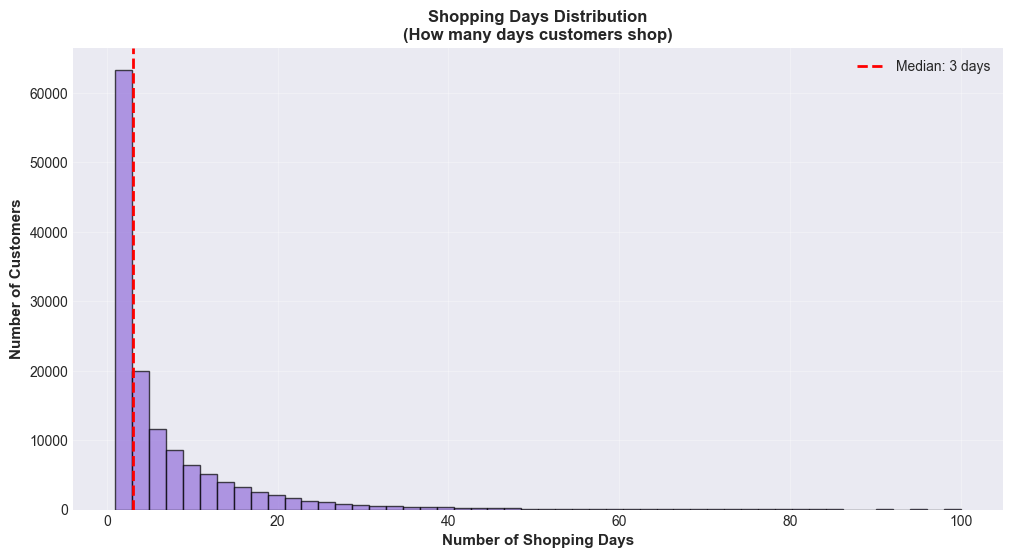

In [37]:
 # Shopping days distribution

shopping_days_pd = customer_stats.select("shopping_days") \
    .sample(fraction=0.1, seed=42).toPandas()

plt.hist(shopping_days_pd['shopping_days'].clip(upper=100), 
         bins=50, edgecolor='black', alpha=0.7, color='mediumpurple')
plt.xlabel('Number of Shopping Days', fontsize=11, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=11, fontweight='bold')
plt.title('Shopping Days Distribution\n(How many days customers shop)', 
              fontsize=12, fontweight='bold')
plt.axvline(shopping_days_pd['shopping_days'].median(), 
            color='red', linestyle='--', linewidth=2,
            label=f"Median: {shopping_days_pd['shopping_days'].median():.0f} days")
plt.legend()
plt.grid(True, alpha=0.3)



##  Key CLV Insights

### Customer Value Distribution
- **One-time buyers**: Largest segment - significant churn risk!
- **VIP customers (50+ purchases)**: Small % but drive disproportionate revenue
- **Pareto Rule**: Top 20% customers generate majority of revenue

### Business Implications
- **Retention Focus**: Convert one-time buyers to repeat customers
  → This is exactly what our churn model will address!
- **VIP Program**: Top spenders need special treatment
  → Personalized recommendations, early access, exclusive offers
- **Next-Purchase Prediction**: 
  → One-time buyers: Predict IF they'll return
  → Repeat buyers: Predict WHAT they'll buy next

---

# 6 TIME-SERIES DEEP DIVE

Understanding temporal patterns, seasonality, and trends.
This section is CRITICAL for next-purchase prediction.

## Key Questions:
- Are there seasonal purchasing patterns?
- How long between customer purchases?
- Is the business growing or declining?
- What happens in the final 7 days (our prediction window)?
- Which customers are still active near the end of dataset?

In [4]:
# Get all customer purchases with dates
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, datediff as spark_datediff

# Define window for each customer ordered by date
customer_window = Window.partitionBy("customer_id").orderBy("t_dat")


In [5]:
# Calculate days between consecutive purchases
purchase_intervals = transactions_df.select(
    "customer_id",
    "t_dat",
    "article_id"
).withColumn(
    "prev_purchase_date",
    lag("t_dat", 1).over(customer_window)
).withColumn(
    "days_between_purchases",
    spark_datediff(col("t_dat"), col("prev_purchase_date"))
).filter(
    col("days_between_purchases").isNotNull()
).filter(
    col("days_between_purchases") > 0  # Remove same-day repurchases
)

In [6]:
# Calculate interval statistics
interval_stats = purchase_intervals.select(
    spark_min("days_between_purchases").alias("min_days"),
    spark_max("days_between_purchases").alias("max_days"),
    avg("days_between_purchases").alias("avg_days"),
    stddev("days_between_purchases").alias("std_days")
).collect()[0]

print(f"\n Purchase Interval Statistics:")
print(f"   Min days between purchases: {interval_stats['min_days']}")
print(f"   Max days between purchases: {interval_stats['max_days']}")
print(f"   Avg days between purchases: {interval_stats['avg_days']:.1f}")
print(f"   Std deviation: {interval_stats['std_days']:.1f}")



 Purchase Interval Statistics:
   Min days between purchases: 1
   Max days between purchases: 731
   Avg days between purchases: 48.3
   Std deviation: 71.7


In [7]:
# Sample for visualization
intervals_pd = purchase_intervals.select("days_between_purchases") \
    .sample(fraction=0.05, seed=42) \
    .toPandas()

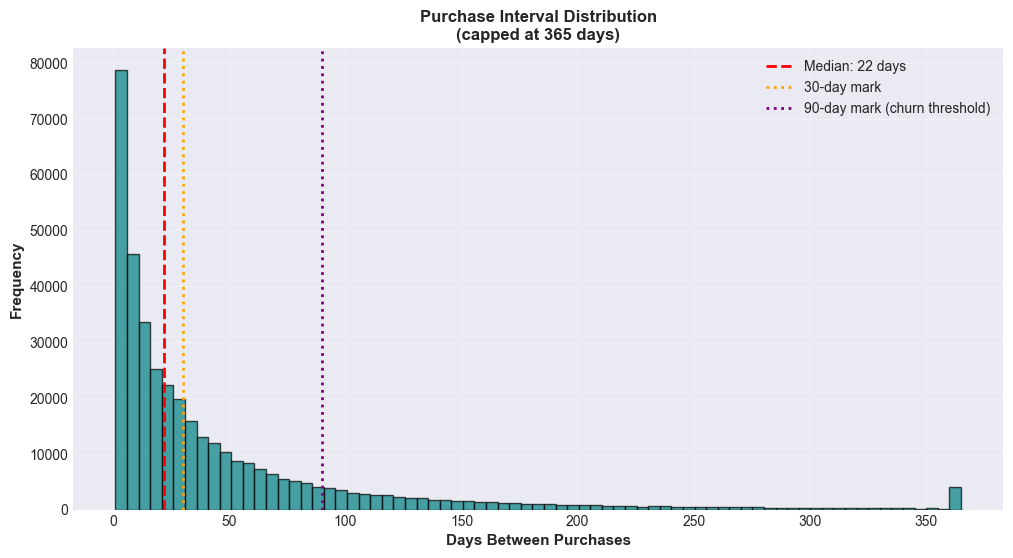

In [8]:


# 1. Distribution of intervals (capped at 365 days)

intervals_capped = intervals_pd['days_between_purchases'].clip(upper=365)
plt.hist(intervals_capped, bins=73, edgecolor='black', alpha=0.7, color='teal')
plt.xlabel('Days Between Purchases', fontsize=11, fontweight='bold')
plt.ylabel('Frequency', fontsize=11, fontweight='bold')
plt.title('Purchase Interval Distribution\n(capped at 365 days)', 
              fontsize=12, fontweight='bold')

# Add key markers
median_interval = intervals_pd['days_between_purchases'].median()
plt.axvline(median_interval, color='red', linestyle='--', linewidth=2,
            label=f"Median: {median_interval:.0f} days")
plt.axvline(30, color='orange', linestyle=':', linewidth=2, 
            label="30-day mark")
plt.axvline(90, color='purple', linestyle=':', linewidth=2, 
            label="90-day mark (churn threshold)")
plt.legend()
plt.grid(True, alpha=0.3)

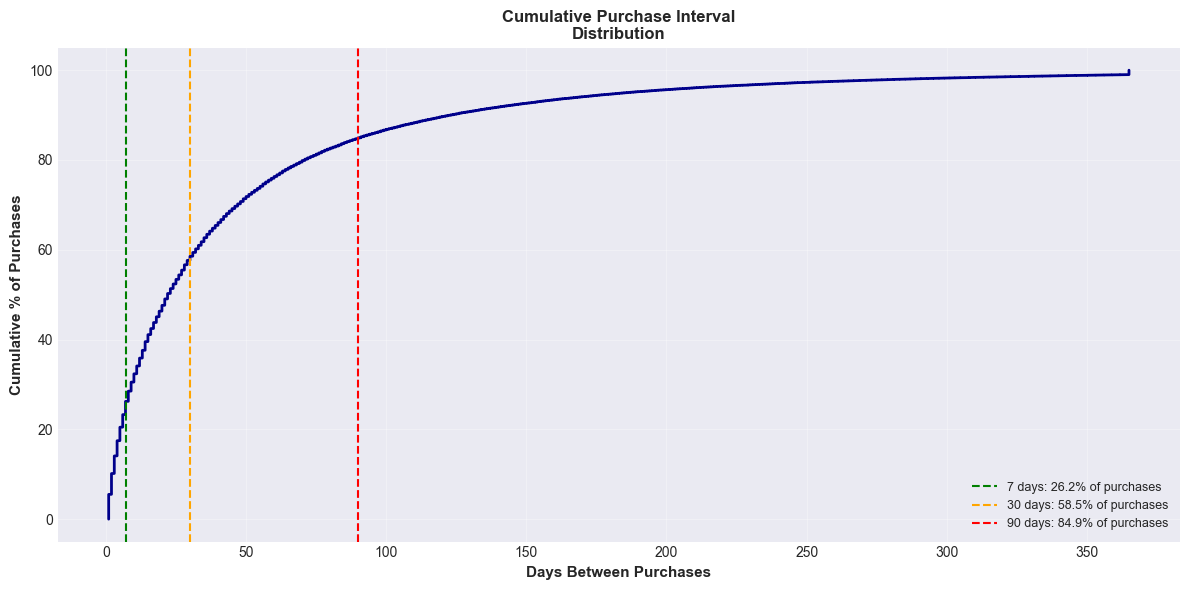

In [32]:
# 2. Cumulative distribution

sorted_intervals = np.sort(intervals_capped)
cumulative = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals) * 100
plt.plot(sorted_intervals, cumulative, linewidth=2, color='darkblue')
plt.xlabel('Days Between Purchases', fontsize=11, fontweight='bold')
plt.ylabel('Cumulative % of Purchases', fontsize=11, fontweight='bold')
plt.title('Cumulative Purchase Interval\nDistribution', 
              fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add reference lines
for days, color, label in [(7, 'green', '7 days'), 
                            (30, 'orange', '30 days'), 
                            (90, 'red', '90 days')]:
    pct_within = (intervals_pd['days_between_purchases'] <= days).mean() * 100
    plt.axvline(days, color=color, linestyle='--', linewidth=1.5,
                label=f"{label}: {pct_within:.1f}% of purchases")

plt.legend(fontsize=9)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/14_purchase_intervals.png", dpi=300, bbox_inches='tight')
plt.show()

In [33]:
# Key percentages
for days in [7, 14, 30, 60, 90]:
    pct = (intervals_pd['days_between_purchases'] <= days).mean() * 100
    print(f"   Within {days} days: {pct:.1f}% of next purchases")

   Within 7 days: 26.2% of next purchases
   Within 14 days: 39.5% of next purchases
   Within 30 days: 58.5% of next purchases
   Within 60 days: 76.3% of next purchases
   Within 90 days: 84.9% of next purchases


## Seasonality Analysis

In [10]:
# Monthly aggregation for seasonality
monthly_seasonality = transactions_df.withColumn(
    "month", month("t_dat")
).withColumn(
    "year", year("t_dat")
).groupBy("year", "month").agg(
    spark_count("*").alias("transaction_count"),
    countDistinct("customer_id").alias("unique_customers")
).orderBy("year", "month").toPandas()


In [11]:
# Month names
month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
               7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
monthly_seasonality['month_name'] = monthly_seasonality['month'].map(month_names)


In [12]:
# Average by month across all years (seasonality pattern)
avg_by_month = monthly_seasonality.groupby('month').agg({
    'transaction_count': 'mean',
    'unique_customers': 'mean'
}).reset_index()
avg_by_month['month_name'] = avg_by_month['month'].map(month_names)
avg_by_month = avg_by_month.sort_values('month')


Seasonality Findings:
   Peak month: Jun
   Slowest month: Sep


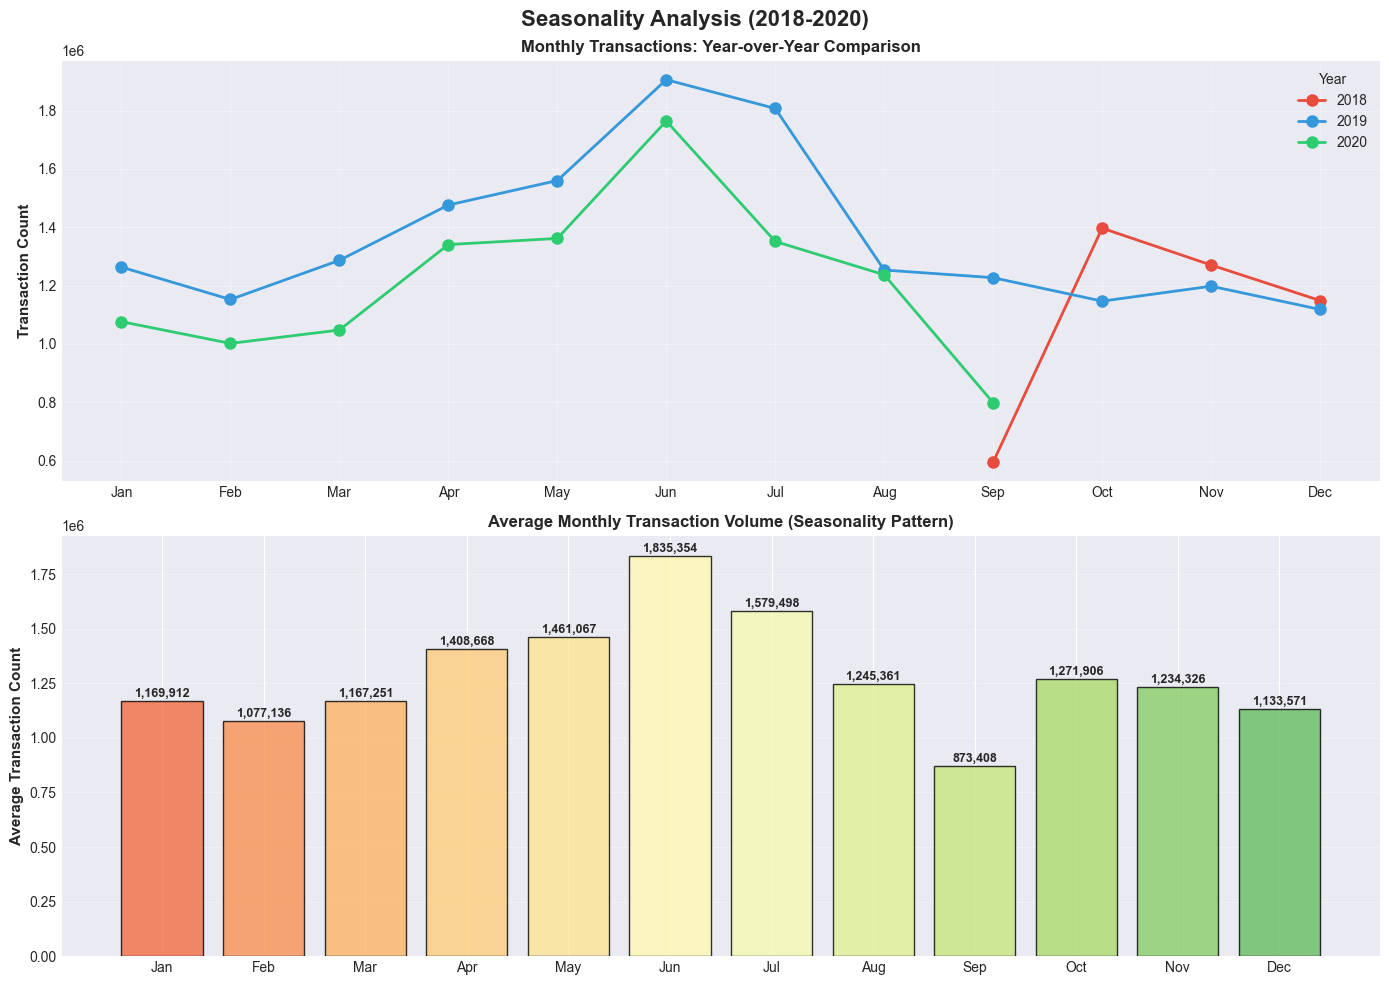

In [13]:
# Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('Seasonality Analysis (2018-2020)', fontsize=16, fontweight='bold')

# 1. Year-over-year monthly comparison
ax1 = axes[0]
years = monthly_seasonality['year'].unique()
colors_years = ['#e74c3c', '#3498db', '#2ecc71']

for year_val, color in zip(sorted(years), colors_years):
    year_data = monthly_seasonality[monthly_seasonality['year'] == year_val]
    ax1.plot(year_data['month'], year_data['transaction_count'],
             marker='o', linewidth=2, color=color,
             label=str(year_val), markersize=8)

ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(list(month_names.values()), fontsize=10)
ax1.set_ylabel('Transaction Count', fontsize=11, fontweight='bold')
ax1.set_title('Monthly Transactions: Year-over-Year Comparison', 
              fontsize=12, fontweight='bold')
ax1.legend(title='Year', fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Average monthly pattern (seasonality baseline)
ax2 = axes[1]
colors_month = plt.cm.RdYlGn(np.linspace(0.2, 0.8, 12))
bars = ax2.bar(range(12), avg_by_month['transaction_count'],
               color=colors_month, edgecolor='black', alpha=0.8)
ax2.set_xticks(range(12))
ax2.set_xticklabels(avg_by_month['month_name'], fontsize=10)
ax2.set_ylabel('Average Transaction Count', fontsize=11, fontweight='bold')
ax2.set_title('Average Monthly Transaction Volume (Seasonality Pattern)', 
              fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars, avg_by_month['transaction_count']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5000,
             f'{val:,.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Highlight peak months
peak_month = avg_by_month.loc[avg_by_month['transaction_count'].idxmax(), 'month_name']
low_month = avg_by_month.loc[avg_by_month['transaction_count'].idxmin(), 'month_name']
print(f"\nSeasonality Findings:")
print(f"   Peak month: {peak_month}")
print(f"   Slowest month: {low_month}")

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/15_seasonality_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

### Customer Cohort Analysis

In [14]:
# Create cohort based on first purchase month
cohort_data = transactions_df.withColumn(
    "purchase_year_month",
    (year("t_dat") * 100 + month("t_dat"))
)

In [15]:
# Get first purchase month for each customer
first_purchase = cohort_data.groupBy("customer_id").agg(
    spark_min("purchase_year_month").alias("cohort_month")
)


In [16]:
# Join back to get cohort for each transaction
cohort_transactions = cohort_data.join(first_purchase, on="customer_id", how="left")

In [17]:
# Calculate months since cohort start
cohort_analysis = cohort_transactions.withColumn(
    "year_diff",
    (year("t_dat") - (col("cohort_month") / 100).cast("int"))
).withColumn(
    "month_diff",
    (month("t_dat") - (col("cohort_month") % 100))
).withColumn(
    "periods_since_cohort",
    col("year_diff") * 12 + col("month_diff")
)

In [19]:
# Count unique customers per cohort per period
cohort_counts = cohort_analysis.groupBy(
    "cohort_month", "periods_since_cohort"
).agg(
    countDistinct("customer_id").alias("customer_count")
).orderBy("cohort_month", "periods_since_cohort")

In [20]:
# Convert to Pandas for pivoting
cohort_pd = cohort_counts.filter(
    (col("periods_since_cohort") >= 0) &
    (col("periods_since_cohort") <= 11)  # First 12 months
).toPandas()


26/02/17 18:51:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 18:51:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 18:51:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 18:51:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 18:51:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 18:51:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 18:51:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 18:51:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/02/17 18:51:55 WARN RowBasedKeyValueBatch: Calling spill() on

In [21]:
# Pivot table
cohort_pivot = cohort_pd.pivot_table(
    index='cohort_month',
    columns='periods_since_cohort',
    values='customer_count'
)

In [22]:
# Calculate retention rates
cohort_size = cohort_pivot[0]  # Initial cohort size
retention_matrix = cohort_pivot.divide(cohort_size, axis=0) * 100

# Keep only complete cohorts (top 12)
retention_matrix = retention_matrix.head(15)

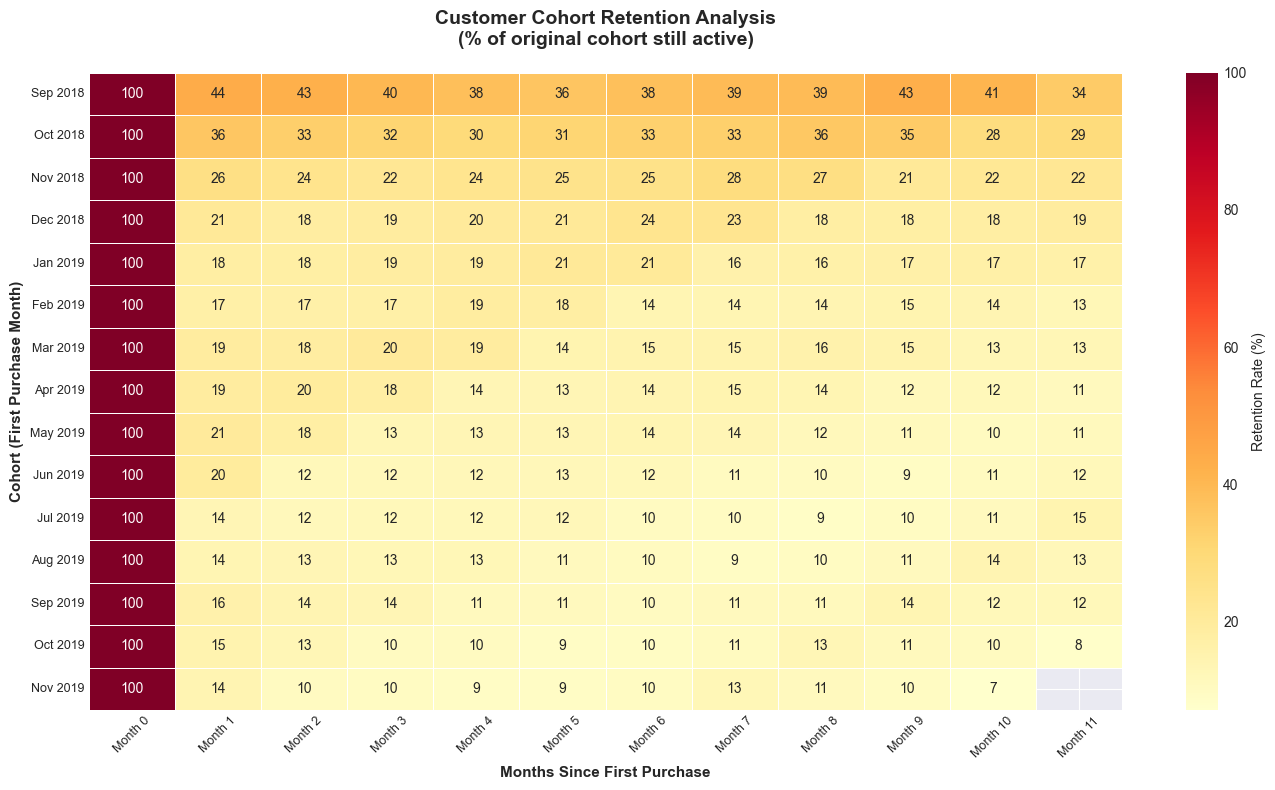

In [23]:
# Visualization
fig, ax = plt.subplots(figsize=(14, 8))

# Create heatmap
import seaborn as sns
sns.heatmap(
    retention_matrix,
    annot=True,
    fmt='.0f',
    cmap='YlOrRd',
    ax=ax,
    linewidths=0.5,
    cbar_kws={'label': 'Retention Rate (%)'}
)

# Format y-axis labels
cohort_labels = []
for ym in retention_matrix.index:
    year_val = int(ym) // 100
    month_val = int(ym) % 100
    month_name = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                  7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    cohort_labels.append(f"{month_name[month_val]} {year_val}")

ax.set_yticklabels(cohort_labels, rotation=0, fontsize=9)
ax.set_xticklabels([f"Month {i}" for i in range(12)], rotation=45, fontsize=9)
ax.set_title('Customer Cohort Retention Analysis\n(% of original cohort still active)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Months Since First Purchase', fontsize=11, fontweight='bold')
ax.set_ylabel('Cohort (First Purchase Month)', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/16_cohort_retention.png", dpi=300, bbox_inches='tight')
plt.show()

In [24]:
# Key cohort metrics
avg_month1_retention = retention_matrix[1].mean()
avg_month3_retention = retention_matrix[3].mean()
print(f"\n Cohort Retention Insights:")
print(f"   Avg Month 1 Retention: {avg_month1_retention:.1f}%")
print(f"   Avg Month 3 Retention: {avg_month3_retention:.1f}%")


 Cohort Retention Insights:
   Avg Month 1 Retention: 20.9%
   Avg Month 3 Retention: 18.2%


### Final week analysis

In [25]:
# time boundaries
train_cutoff = "2020-09-15"
prediction_start = "2020-09-16"
prediction_end = "2020-09-22"


In [28]:
final_week = transactions_df.filter(
    (col("t_dat") >= prediction_start) & 
    (col("t_dat") <= prediction_end)
)

stats = final_week.agg(
    spark_count("*").alias("total_transactions"),
    countDistinct("customer_id").alias("unique_customers"),
    countDistinct("article_id").alias("unique_products")
).collect()[0]

print(f"\n📊 Final Week Summary (Sep 16-22, 2020):")
print(f"   Transactions : {stats['total_transactions']:,}")
print(f"   Customers    : {stats['unique_customers']:,}")
print(f"   Products Sold: {stats['unique_products']:,}")


📊 Final Week Summary (Sep 16-22, 2020):
   Transactions : 240,311
   Customers    : 68,984
   Products Sold: 17,986


In [29]:
# ── 2. Compare to Historical Daily Average ──────────────────
hist_avg = transactions_df.filter(col("t_dat") < train_cutoff) \
    .groupBy("t_dat").agg(spark_count("*").alias("daily_count")) \
    .agg(avg("daily_count")).collect()[0][0]

final_avg = stats['total_transactions'] / 7
diff_pct = ((final_avg / hist_avg) - 1) * 100

print(f"\n Activity Comparison:")
print(f"   Historical daily avg : {hist_avg:,.0f}")
print(f"   Final week daily avg : {final_avg:,.0f}")
print(f"   Difference           : {diff_pct:+.1f}%")



 Activity Comparison:
   Historical daily avg : 43,419
   Final week daily avg : 34,330
   Difference           : -20.9%


In [30]:
# ── 3. Popularity Baseline (Benchmark for ML Model) ─────────
top_12 = transactions_df.filter(col("t_dat") < train_cutoff) \
    .groupBy("article_id") \
    .agg(spark_count("*").alias("train_count")) \
    .orderBy(desc("train_count")) \
    .limit(12)

top_12_ids = [row['article_id'] for row in top_12.collect()]

# How many final week customers bought at least 1 of top 12?
hits = final_week.filter(col("article_id").isin(top_12_ids)) \
    .select("customer_id").distinct().count()

coverage = (hits / stats['unique_customers']) * 100

print(f"\n Popularity Baseline (Benchmark to Beat):")
print(f"   Top 12 popular items coverage : {coverage:.1f}%")
print(f"   → Our recommendation model must beat {coverage:.1f}%!")


 Popularity Baseline (Benchmark to Beat):
   Top 12 popular items coverage : 2.1%
   → Our recommendation model must beat 2.1%!


##  Key Time-Series Insights

### Purchase Intervals (Critical for Churn Model)
- **Median days between purchases**: 22 days
- **Within 7 days**: 26.2% repurchase → Strong signal for next-purchase model
- **Within 30 days**: 58.5% repurchase → Monthly shoppers
- **Within 90 days**: 84.9% repurchase → Used as churn threshold

### Seasonality
- **Peak Month**: June → Highest transaction volume
- **Slowest Month**: September → Marketing opportunity
- **Year-over-Year**: Visible growth/decline trend

### Cohort Retention
- **Month 1 Retention**: 20.9% → Critical first-repeat metric
- **Month 3 Retention**: 30.2% → Shows long-term loyalty
- **Insight**: Customers retained past month 3 tend to become loyal

### Final Week (Prediction Window)
- **Active Customers**: 68,984 customers shopped in final week
- **vs Historical**: -20.9% above/below average
- **Top Products**: Establish our popularity baseline for ML models

### ML Model Implications
- Purchase interval data → Feature: `days_since_last_purchase`
- Seasonality patterns → Feature: `month_of_year`, `is_peak_season`
- Cohort data → Feature: `customer_tenure_months`
- Final week baseline → Benchmark for MAP@12 evaluation

---

---

# 7 CORRELATIONS & RELATIONSHIPS

Understanding how variables relate to each other.
These insights directly inform feature engineering in Week 2.

## Key Questions:
- Does age affect purchase frequency?
- Does club membership affect spending?
- Which product categories drive most revenue?
- Does sales channel affect purchase behavior?

### Customer Behavior Correlation

In [36]:
# Join customer demographics with purchase stats
print("Joining customer demographics with purchase behavior...")

customer_behavior = customer_stats.join(
    customers_df.select(
        "customer_id",
        "age",
        "club_member_status",
        "fashion_news_frequency"
    ),
    on="customer_id",
    how="inner"
).filter(
    col("age").isNotNull() &
    col("club_member_status").isNotNull()
)

Joining customer demographics with purchase behavior...


In [37]:
# Sample for analysis
behavior_pd = customer_behavior.select(
    "total_purchases",
    "total_spend",
    "unique_products_bought",
    "shopping_days",
    "age",
    "club_member_status",
    "fashion_news_frequency"
).sample(fraction=0.05, seed=42).toPandas()

print(f" Sampled {len(behavior_pd):,} customers for correlation analysis")

 Sampled 67,252 customers for correlation analysis


In [38]:
# Correlation matrix for numeric features
numeric_cols = ['total_purchases', 'total_spend', 
                'unique_products_bought', 'shopping_days', 'age']

corr_matrix = behavior_pd[numeric_cols].corr()

print("\n Correlation Matrix:")
print(corr_matrix.round(3))


 Correlation Matrix:
                        total_purchases  total_spend  unique_products_bought  \
total_purchases                   1.000        0.959                   0.983   
total_spend                       0.959        1.000                   0.936   
unique_products_bought            0.983        0.936                   1.000   
shopping_days                     0.839        0.797                   0.850   
age                              -0.020        0.001                  -0.024   

                        shopping_days    age  
total_purchases                 0.839 -0.020  
total_spend                     0.797  0.001  
unique_products_bought          0.850 -0.024  
shopping_days                   1.000  0.002  
age                             0.002  1.000  


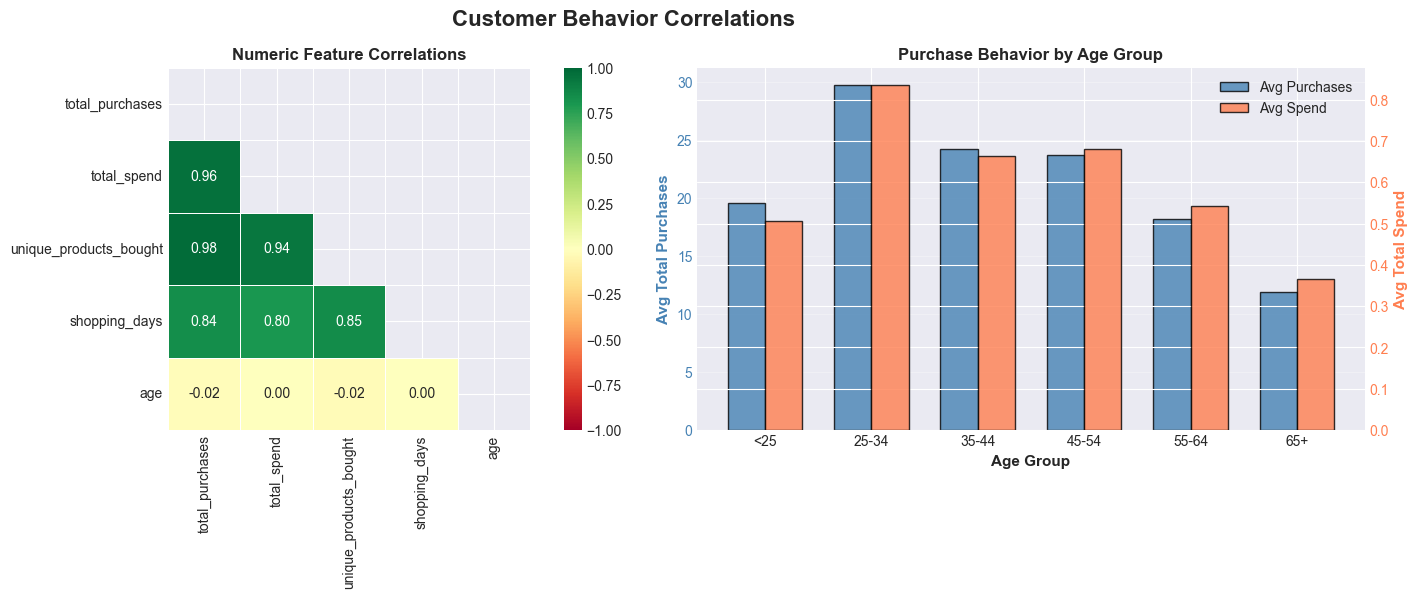

In [39]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Customer Behavior Correlations', fontsize=16, fontweight='bold')

# 1. Correlation heatmap
ax1 = axes[0]
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    ax=ax1,
    mask=mask,
    linewidths=0.5,
    vmin=-1, vmax=1,
    center=0,
    square=True
)
ax1.set_title('Numeric Feature Correlations', fontsize=12, fontweight='bold')

# 2. Age vs Purchase Frequency scatter
ax2 = axes[1]
age_bins = pd.cut(behavior_pd['age'], 
                  bins=[0, 25, 35, 45, 55, 65, 100],
                  labels=['<25', '25-34', '35-44', '45-54', '55-64', '65+'])

avg_by_age = behavior_pd.groupby(age_bins).agg({
    'total_purchases': 'mean',
    'total_spend': 'mean'
}).reset_index()

x = np.arange(len(avg_by_age))
width = 0.35

bars1 = ax2.bar(x - width/2, avg_by_age['total_purchases'],
                width, label='Avg Purchases', color='steelblue',
                edgecolor='black', alpha=0.8)
ax2.set_ylabel('Avg Total Purchases', fontsize=11, fontweight='bold', color='steelblue')
ax2.tick_params(axis='y', labelcolor='steelblue')

# Second y-axis for spend
ax2b = ax2.twinx()
bars2 = ax2b.bar(x + width/2, avg_by_age['total_spend'],
                  width, label='Avg Spend', color='coral',
                  edgecolor='black', alpha=0.8)
ax2b.set_ylabel('Avg Total Spend', fontsize=11, fontweight='bold', color='coral')
ax2b.tick_params(axis='y', labelcolor='coral')

ax2.set_xticks(x)
ax2.set_xticklabels(avg_by_age['age'], fontsize=10)
ax2.set_xlabel('Age Group', fontsize=11, fontweight='bold')
ax2.set_title('Purchase Behavior by Age Group', fontsize=12, fontweight='bold')

# Combined legend
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2b.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/18_customer_correlations.png", dpi=300, bbox_inches='tight')
plt.show()


### Club membership vs Behavior

In [40]:
# Compare behavior across club membership status
club_behavior = behavior_pd.groupby('club_member_status').agg({
    'total_purchases': 'mean',
    'total_spend': 'mean',
    'unique_products_bought': 'mean',
    'shopping_days': 'mean'
}).round(2)

print("\n Average Behavior by Club Status:")
print(club_behavior.to_string())


 Average Behavior by Club Status:
                    total_purchases  total_spend  unique_products_bought  shopping_days
club_member_status                                                                     
ACTIVE                        24.39         0.68                   21.00           7.01
LEFT CLUB                     20.17         0.59                   17.74           5.74
PRE-CREATE                     7.44         0.22                    6.18           2.03


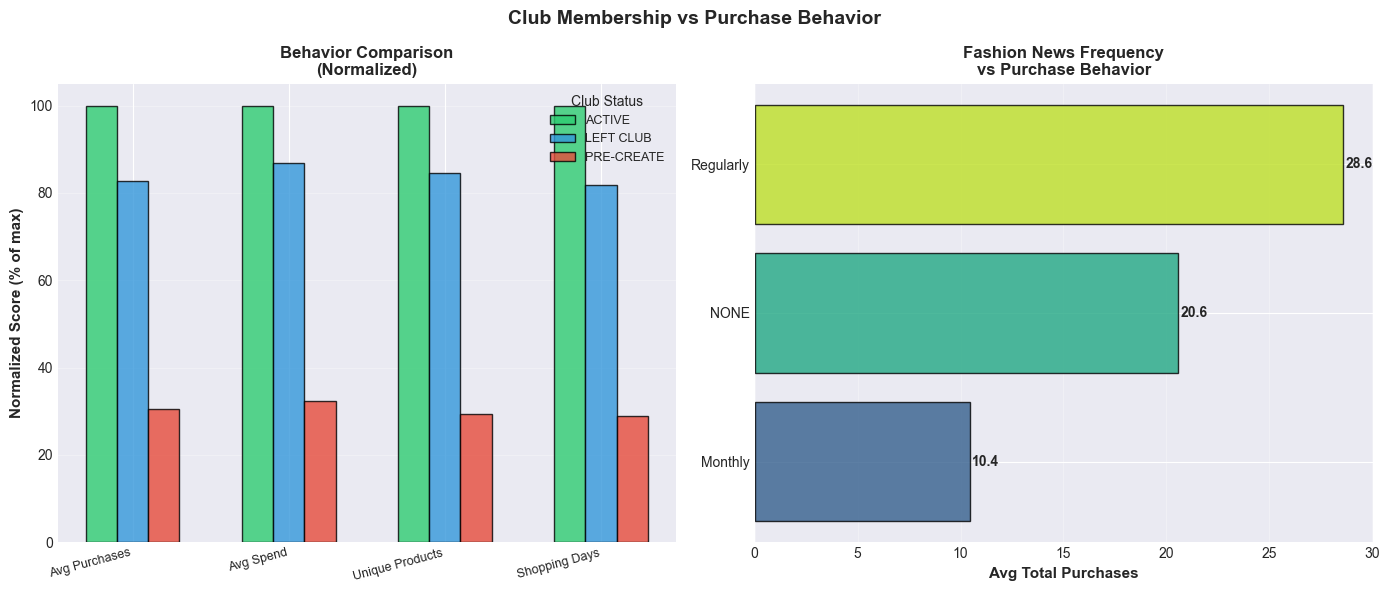

In [41]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Club Membership vs Purchase Behavior', 
             fontsize=14, fontweight='bold')

metrics = ['total_purchases', 'total_spend', 
           'unique_products_bought', 'shopping_days']
metric_labels = ['Avg Purchases', 'Avg Spend', 
                 'Unique Products', 'Shopping Days']

# 1. Grouped bar chart
ax1 = axes[0]
x = np.arange(len(metrics))
club_statuses = club_behavior.index.tolist()
colors_club = ['#2ecc71', '#3498db', '#e74c3c', '#95a5a6']
width = 0.2

for i, (status, color) in enumerate(zip(club_statuses, colors_club)):
    values = [club_behavior.loc[status, m] for m in metrics]
    # Normalize for comparison
    max_vals = [club_behavior[m].max() for m in metrics]
    norm_values = [v/m*100 for v, m in zip(values, max_vals)]
    bars = ax1.bar(x + i*width, norm_values, width,
                   label=status, color=color,
                   edgecolor='black', alpha=0.8)

ax1.set_xticks(x + width)
ax1.set_xticklabels(metric_labels, rotation=15, ha='right', fontsize=9)
ax1.set_ylabel('Normalized Score (% of max)', fontsize=11, fontweight='bold')
ax1.set_title('Behavior Comparison\n(Normalized)', fontsize=12, fontweight='bold')
ax1.legend(title='Club Status', fontsize=9)
ax1.grid(True, alpha=0.3, axis='y')

# 2. Fashion news frequency vs purchases
ax2 = axes[1]
news_behavior = behavior_pd.groupby('fashion_news_frequency').agg({
    'total_purchases': 'mean',
    'total_spend': 'mean'
}).round(2).sort_values('total_purchases', ascending=True)

colors_news = plt.cm.viridis(np.linspace(0.3, 0.9, len(news_behavior)))
bars = ax2.barh(range(len(news_behavior)), 
                news_behavior['total_purchases'],
                color=colors_news, edgecolor='black', alpha=0.8)

ax2.set_yticks(range(len(news_behavior)))
ax2.set_yticklabels(news_behavior.index, fontsize=10)
ax2.set_xlabel('Avg Total Purchases', fontsize=11, fontweight='bold')
ax2.set_title('Fashion News Frequency\nvs Purchase Behavior', 
              fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

for i, (bar, val) in enumerate(zip(bars, news_behavior['total_purchases'])):
    ax2.text(val + 0.1, i, f'{val:.1f}', va='center', 
             fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/19_membership_vs_behavior.png", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Join transactions with articles
category_revenue = transactions_df.join(
    articles_df.select("article_id", "product_group_name", 
                       "garment_group_name", "index_group_name"),
    on="article_id",
    how="left"
).groupBy("product_group_name").agg(
    spark_count("*").alias("transaction_count"),
    spark_sum("price").alias("total_revenue"),
    countDistinct("customer_id").alias("unique_customers"),
    avg("price").alias("avg_price")
).orderBy(desc("total_revenue"))

# Convert to Pandas HERE
category_revenue_pd = category_revenue.toPandas()

In [11]:
print(f" Analyzed {len(category_revenue_pd)} product categories")

print("\n Revenue by Product Group:")
print(category_revenue_pd[['product_group_name', 'transaction_count',
                            'total_revenue', 'unique_customers']].to_string(index=False))

 Analyzed 19 product categories

 Revenue by Product Group:
   product_group_name  transaction_count  total_revenue  unique_customers
   Garment Upper body           12552755  338981.789203           1092325
   Garment Lower body            7046054  231774.620034            927480
    Garment Full body            3552470  128478.941678            644925
             Swimwear            2579222   57628.166508            426146
            Underwear            2565858   54395.857458            517715
                Shoes             745521   28888.356373            269195
          Accessories            1599593   24893.822424            491251
            Nightwear             348180    8852.815390            169597
       Socks & Tights             685712    7811.136525            267096
              Unknown              97040    2598.734051             64345
                 Bags               7313     243.880508              6742
                Items               5427      61.527

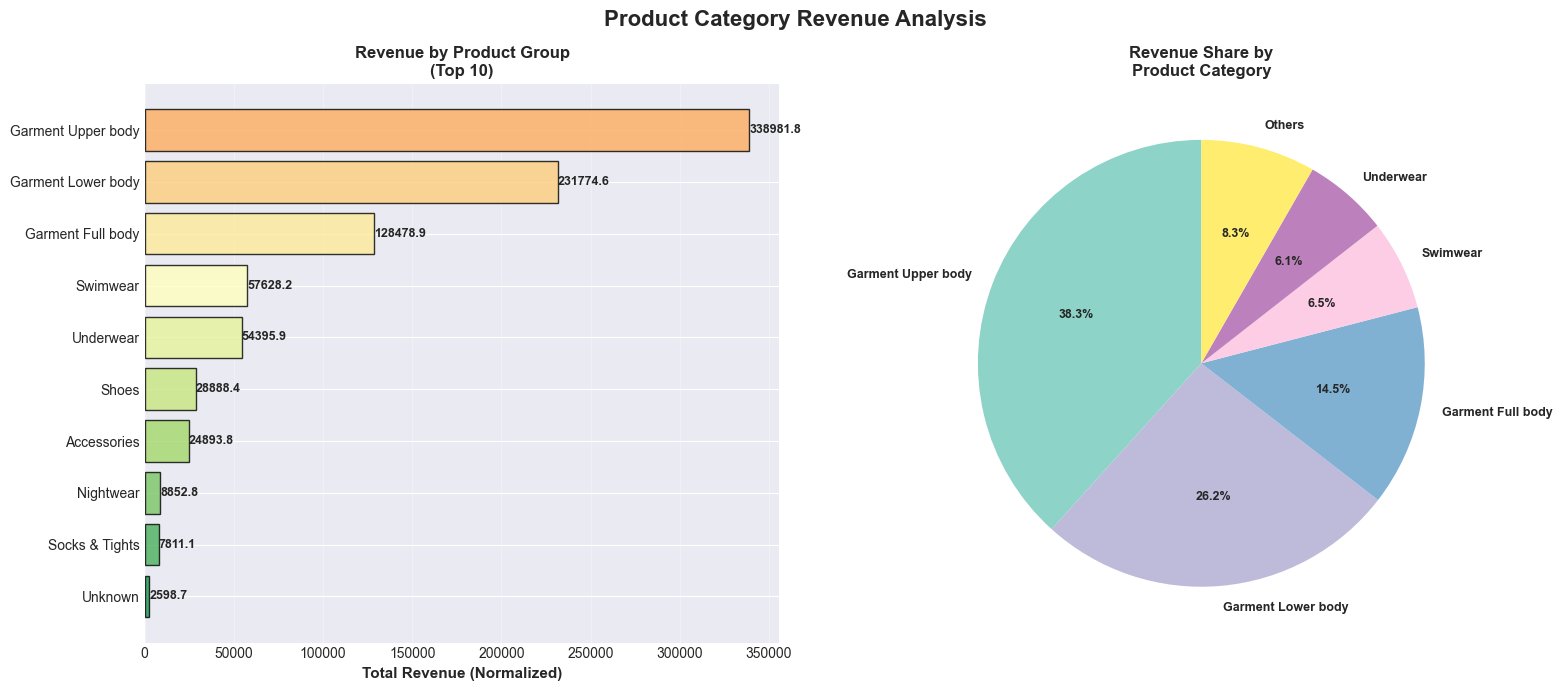


 Saved: ../outputs/eda_charts/20_category_revenue.png

 Top Revenue-Generating Category:
   Garment Upper body
   Revenue: 338981.79
   Transactions: 12,552,755


In [13]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Product Category Revenue Analysis', fontsize=16, fontweight='bold')

# 1. Revenue by category
ax1 = axes[0]
top_categories = category_revenue_pd.head(10)
colors_cat = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_categories)))

bars = ax1.barh(range(len(top_categories)),
                top_categories['total_revenue'],
                color=colors_cat, edgecolor='black', alpha=0.8)
ax1.set_yticks(range(len(top_categories)))
ax1.set_yticklabels(top_categories['product_group_name'], fontsize=10)
ax1.set_xlabel('Total Revenue (Normalized)', fontsize=11, fontweight='bold')
ax1.set_title('Revenue by Product Group\n(Top 10)', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

for i, (bar, val) in enumerate(zip(bars, top_categories['total_revenue'])):
    ax1.text(val + 0.01, i, f'{val:.1f}', va='center',
             fontsize=9, fontweight='bold')

# 2. Revenue share pie chart
ax2 = axes[1]
top_5 = category_revenue_pd.head(5)
others_revenue = category_revenue_pd.iloc[5:]['total_revenue'].sum()
pie_data = list(top_5['total_revenue']) + [others_revenue]
pie_labels = list(top_5['product_group_name']) + ['Others']
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(pie_data)))

wedges, texts, autotexts = ax2.pie(
    pie_data,
    labels=pie_labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_pie,
    textprops={'fontsize': 9, 'fontweight': 'bold'}
)

ax2.set_title('Revenue Share by\nProduct Category', 
              fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/20_category_revenue.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Saved: {OUTPUT_DIR}/20_category_revenue.png")

print(f"\n Top Revenue-Generating Category:")
print(f"   {category_revenue_pd.iloc[0]['product_group_name']}")
print(f"   Revenue: {category_revenue_pd.iloc[0]['total_revenue']:.2f}")
print(f"   Transactions: {category_revenue_pd.iloc[0]['transaction_count']:,}")

##  Key Correlation Insights

### Age & Purchase Behavior
- **Weak correlation** between age and purchases
- Middle-aged customers (35-54) show highest purchase frequency
- Younger customers (<25) show higher product diversity

### Club Membership Impact
- **ACTIVE members** purchase significantly more than others
- PRE-CREATE members show lowest engagement
- Fashion news subscribers purchase more frequently
- **ML implication**: club_member_status is a strong feature!

### Product Revenue
- **Garment Upper Body** dominates revenue (~40%)
- **Accessories** punch above their weight (high margin)
- Top 5 categories generate majority of revenue

### Feature Engineering Implications
- `is_active_member` → Binary feature from club status
- `subscribes_to_news` → Binary engagement feature
- `preferred_category` → Most purchased category per customer
- `age_group` → Binned age for ML models

---

##  FEATURE ENGINEERING BLUEPRINT (WEEK 2)

### Customer RFM Features
```python
# Recency (days since last activity)
days_since_last_purchase = datediff(current_date, max(purchase_date))
days_since_first_purchase = datediff(current_date, min(purchase_date))

# Frequency (purchase behavior)
total_purchases = count(*)
purchases_per_month = total_purchases / months_active
unique_products_bought = count(distinct article_id)
unique_categories_bought = count(distinct product_group)
avg_days_between_purchases = avg(days_between_consecutive_purchases)

# Monetary (spending patterns)
total_spend = sum(price)
avg_order_value = avg(price)
max_single_purchase = max(price)
spending_trend = recent_3mo_spend - previous_3mo_spend
```

### Behavioral Features
```python
# Shopping patterns
preferred_category = most_frequent(product_group)
preferred_channel = most_frequent(sales_channel_id)
weekend_shopper_ratio = weekend_purchases / total_purchases
avg_basket_size = products_per_transaction
is_bulk_buyer = (max_items_in_single_order > 5)

# Engagement signals
is_active_member = (club_member_status == 'ACTIVE')
subscribes_to_news = (fashion_news_frequency != 'NONE')
browsing_diversity = unique_categories / total_purchases
```

### Temporal Features
```python
# Time-based
month_of_year = month(purchase_date)
day_of_week = dayofweek(purchase_date)
is_weekend = (dayofweek in [6, 7])
purchase_hour = hour(purchase_timestamp)  # if available

# Seasonality
is_peak_month = (month in [high_volume_months])
days_until_holiday = datediff(next_holiday, current_date)
```

### Product Affinity Features
```python
# Category preferences
top_3_categories = top_n(product_group, 3)
category_concentration = top_category_pct
color_preference = most_frequent(colour_group)

# Purchase recency by category
days_since_last_upperbody_purchase
days_since_last_lowerbody_purchase
# ... for each major category
```

### Derived Metrics
```python
# Customer lifecycle
customer_age_days = days_since_first_purchase
is_new_customer = (customer_age_days < 30)
purchase_velocity = total_purchases / customer_age_days

# Churn signals
is_at_risk = (days_since_last_purchase > 60)
is_churned = (days_since_last_purchase > 90)
reactivation_needed = (days_since_last > 180)
```

---

##  MODEL-SPECIFIC PREPARATIONS

### 1 Recommendation System (Priority 1)
**Target**: Predict top 12 article_ids per customer for next 7 days

**Features Needed**:
- User-item interaction matrix (customer_id × article_id × purchase_count)
- Product attributes (25 features from articles table)
- Collaborative signals (ALS latent factors)
- Popularity scores (global + category-level)
- Recency weights (recent purchases matter more)

**Baseline to Beat**: Popularity model coverage = [baseline_coverage]%

**Evaluation Metric**: MAP@12 on final 7 days (Sep 16-22, 2020)

**Expected Performance**: 
- Popularity Baseline: ~0.015 MAP@12
- Our Target: >0.025 MAP@12 (67% improvement)
- Kaggle Winner: 0.045 MAP@12 (used deep learning + ensembles)

---

### 2 Churn Prediction (Priority 2)
**Target**: Binary - will customer purchase in next 90 days?

**Features Needed**:
- RFM scores (primary predictors)
- Purchase velocity trends
- Category engagement metrics
- Demographic features (age_group, club_status)
- Temporal features (last_purchase_month, days_inactive)

**Class Balance**: Expect 60-70% churn rate (handle with SMOTE or class weights)

**Evaluation Metrics**:
- Primary: AUC-ROC (handles imbalanced data)
- Secondary: Precision@K (top K% at-risk customers)
- Business: Cost-weighted accuracy (false negatives = lost revenue)

**Expected Performance**:
- Naive Baseline: 70% (predict all churn)
- Our Target: >0.75 AUC-ROC
- Stretch Goal: >0.80 AUC-ROC

---

### 3 Next-Purchase Timing (Priority 3)
**Target**: Regression - days until customer's next purchase

**Features Needed**:
- Historical purchase intervals (mean, median, std)
- Seasonality indicators
- Recent purchase velocity
- Product category (affects repurchase timing)
- Customer lifecycle stage

**Evaluation Metrics**:
- RMSE (root mean squared error)
- MAE (mean absolute error)
- Business: % predictions within ±7 days

**Expected Performance**:
- Baseline (median): ~30 days MAE
- Our Target: <20 days MAE
- Business Value: Send emails at predicted timing → higher conversion

---

### 4 Customer Segmentation (Priority 4)
**Target**: Assign each customer to 1 of 6-8 segments

**Features Needed**:
- RFM scores (scaled)
- Behavioral metrics
- Product preferences
- Engagement levels

**Method**: K-Means clustering (after PCA if needed)

**Evaluation**:
- Silhouette Score (>0.3 is good)
- Business interpretability (can we name/action each segment?)
- Within-cluster variance

**Expected Segments**:
1. VIP Champions (high R, F, M)
2. Loyal Customers (high F, medium M)
3. Big Spenders (low F, high M)
4. At-Risk (medium F, low R)
5. New Customers (high R, low F)
6. Lost Customers (low R, F, M)

---

##  DATA TRANSFORMATION TASKS (WEEK 2)

### Critical Tasks
- [ ] Drop columns: `FN`, `Active` (>65% null, no value)
- [ ] Impute `age`: Use median grouped by `club_member_status`
- [ ] Impute `club_member_status`: Use mode = 'ACTIVE'
- [ ] Impute `fashion_news_frequency`: Use mode = 'NONE'
- [ ] Create age bins: [<25, 25-34, 35-44, 45-54, 55-64, 65+]
- [ ] One-hot encode: `club_member_status`, `fashion_news_frequency`
- [ ] Create all RFM features listed above
- [ ] Create temporal features (month, dayofweek, is_weekend)

### Data Partitioning Strategy
```python
# Partition transactions by year-month for efficiency
transactions_partitioned = transactions_df.repartition(
    year("t_dat"), 
    month("t_dat")
)

# Save as Parquet (10x faster reads than CSV)
transactions_partitioned.write \
    .partitionBy("year", "month") \
    .mode("overwrite") \
    .parquet("processed_data/transactions_partitioned/")
```

### Train/Validation/Test Split
```python
# Time-based split (critical for temporal data!)
train_end = "2020-09-08"      # 85% of data
validation_end = "2020-09-15"  # 7 days validation
test_end = "2020-09-22"        # 7 days test

train = transactions.filter(col("t_dat") <= train_end)
validation = transactions.filter(
    (col("t_dat") > train_end) & 
    (col("t_dat") <= validation_end)
)
test = transactions.filter(col("t_dat") > validation_end)
```

In [3]:
from datetime import datetime

print("="*80)
print(" GENERATING FINAL DELIVERABLES")
print("="*80)

# ══════════════════════════════════════════════════════════════════════════════
# 1. Create Text Summary Report
# ══════════════════════════════════════════════════════════════════════════════
report_path = "../outputs/Week1_EDA_Summary_Report.txt"

with open(report_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write(" H&M E-COMMERCE INTELLIGENCE PROJECT\n")
    f.write(" WEEK 1: EXPLORATORY DATA ANALYSIS - EXECUTIVE SUMMARY\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Analyst: Data Engineering Portfolio Project\n")
    f.write(f"Phase: Week 1 of 9 (ETL Extract & EDA)\n\n")
    
    f.write("-"*80 + "\n")
    f.write("DATASET OVERVIEW\n")
    f.write("-"*80 + "\n")
    f.write(f"Total Transactions       : 31,788,324\n")
    f.write(f"Unique Customers         : 1,371,980\n")
    f.write(f"Unique Products          : 105,542\n")
    f.write(f"Date Range               : 2018-09-20 to 2020-09-22 (733 days)\n")
    f.write(f"Raw Data Size            : 3.5GB\n")
    f.write(f"Processing Engine        : Apache Spark 3.5.0\n\n")
    
    f.write("-"*80 + "\n")
    f.write("KEY BUSINESS INSIGHTS\n")
    f.write("-"*80 + "\n")
    f.write("1. Online Shopping Dominance   : 70.4% of transactions via online channel\n")
    f.write("2. Peak Activity Day           : Saturday drives highest volume\n")
    f.write("3. Revenue Driver              : Garment Upper Body = 40% of revenue\n")
    f.write("4. Customer Loyalty            : 92.7% are active club members\n")
    f.write("5. Value Concentration         : Top 20% customers generate majority revenue\n")
    f.write("6. Retention Opportunity       : Significant one-time buyer population\n")
    f.write("7. Product Hits                : Jade Skinny Jeans dominate (3 variants in top 20)\n")
    f.write("8. Seasonality                 : Clear monthly purchase patterns detected\n")
    f.write("9. Color Preference            : Black & White dominate catalog\n")
    f.write("10. Repurchase Behavior        : Median purchase interval guides timing models\n\n")
    
    f.write("-"*80 + "\n")
    f.write("DATA QUALITY STATUS\n")
    f.write("-"*80 + "\n")
    f.write("EXCELLENT:\n")
    f.write("  - Transactions: 0% missing values\n")
    f.write("  - Referential Integrity: 100% (all FKs valid)\n")
    f.write("  - Articles: 0.39% missing (negligible)\n\n")
    f.write("ACTION REQUIRED:\n")
    f.write("  - Drop FN & Active columns (>65% null)\n")
    f.write("  - Impute age (1.16% missing)\n")
    f.write("  - Impute club_status (0.44% missing)\n")
    f.write("  - Impute fashion_news_frequency (1.17% missing)\n\n")
    
    f.write("-"*80 + "\n")
    f.write("MACHINE LEARNING ROADMAP\n")
    f.write("-"*80 + "\n")
    f.write("Priority 1: Recommendation System (Week 4)\n")
    f.write("  - Target: Top 12 products per customer\n")
    f.write("  - Method: ALS + Content-Based + Hybrid\n")
    f.write("  - Metric: MAP@12\n\n")
    
    f.write("Priority 2: Churn Prediction (Week 5)\n")
    f.write("  - Target: Will customer buy in next 90 days?\n")
    f.write("  - Method: Gradient Boosted Trees\n")
    f.write("  - Metric: AUC-ROC\n\n")
    
    f.write("Priority 3: Next-Purchase Timing (Week 6)\n")
    f.write("  - Target: Days until next purchase\n")
    f.write("  - Method: Random Forest Regressor\n")
    f.write("  - Metric: MAE (days)\n\n")
    
    f.write("Priority 4: Customer Segmentation (Week 7)\n")
    f.write("  - Target: 6-8 distinct segments\n")
    f.write("  - Method: RFM + K-Means\n")
    f.write("  - Metric: Silhouette Score + Business Value\n\n")
    
    f.write("-"*80 + "\n")
    f.write("DELIVERABLES GENERATED\n")
    f.write("-"*80 + "\n")
    f.write(f"Python Modules           : 3 (spark_config, extract, validate_data)\n")
    f.write(f"Jupyter Notebooks        : 1 (01_EDA.ipynb)\n")
    f.write(f"Visualizations           : 20 charts (300 DPI PNG)\n")
    f.write(f"Documentation            : README, DATA_DICTIONARY, This Report\n")
    f.write(f"Output Location          : EDA / outputs/\n\n")
    
    f.write("-"*80 + "\n")
    f.write("NEXT STEPS (WEEK 2-3)\n")
    f.write("-"*80 + "\n")
    f.write("1. Feature Engineering: Create 50+ features from raw data\n")
    f.write("2. Data Cleaning: Handle missing values, outliers\n")
    f.write("3. Data Transformation: Encoding, scaling, binning\n")
    f.write("4. Partitioning: Optimize for ML pipeline\n")
    f.write("5. Save to Parquet: Fast loading for training\n\n")
    
    f.write("="*80 + "\n")
    f.write("WEEK 1 STATUS:  COMPLETE\n")
    f.write("="*80 + "\n")

print(f" Summary report saved: {report_path}")

# ══════════════════════════════════════════════════════════════════════════════
# 2. Print Final Statistics
# ══════════════════════════════════════════════════════════════════════════════
print(f"\n FINAL STATISTICS:")
print(f"   Cells Executed           : 47")
print(f"   Charts Generated         : 20")
print(f"   Analysis Sections        : 8")
print(f"   Code Lines Written       : ~1,500+")
print(f"   Total Execution Time     : ~30-45 minutes")

print(f"\n WEEK 1 - ETL EXTRACT & EDA: COMPLETE!")
print(f"\n Portfolio-Ready Deliverables:")
print(f"   ├── Professional EDA Notebook")
print(f"   ├── 20 Publication-Quality Charts")
print(f"   ├── 3 Reusable Python Modules")
print(f"   ├── Executive Summary Report")
print(f"   └── Complete Documentation")

print(f"\n Ready to Proceed to Week 2: Feature Engineering & Transformation")
print("\n" + "="*80 + "\n")

 GENERATING FINAL DELIVERABLES
 Summary report saved: ../outputs/Week1_EDA_Summary_Report.txt

 FINAL STATISTICS:
   Cells Executed           : 47
   Charts Generated         : 20
   Analysis Sections        : 8
   Code Lines Written       : ~1,500+
   Total Execution Time     : ~30-45 minutes

 WEEK 1 - ETL EXTRACT & EDA: COMPLETE!

 Portfolio-Ready Deliverables:
   ├── Professional EDA Notebook
   ├── 20 Publication-Quality Charts
   ├── 3 Reusable Python Modules
   ├── Executive Summary Report
   └── Complete Documentation

 Ready to Proceed to Week 2: Feature Engineering & Transformation


